### This file contains the post-processing code for the sensitivity analysis of the proposed method's $M$ and $w_3$.

1. `/Reproduction/Analysis-SA/SA-M/` and `/Reproduction/Analysis-SA/SA-w3/` contain the metrics for each data split under different $M$ and $w_3$ values. For example, `/Reproduction/Analysis-SA/SA-M/Metrics-25.xlsx` contains the metrics for each data split for $M=25$.

2. `/Reproduction/Analysis-SA/SA-M/M...` and `/Reproduction/Analysis-SA/SA-w3/w3...` contain the metrics for each test well inside each data split for the corresponding $M$ or $w_3$. For example, `/Reproduction/Analysis-SA/SA-M/M25/` contains the metrics for each test well inside each data split for $M=25$.

3. Specifically, the numerical results in the abstract of the manuscript can be derived from `/Reproduction/Analysis-SA/SA-M/Metrics-200.xlsx`. For example, the proposed method's average overall mean absolute percentage error (OMAPE) is the average value of column `Proposed_omape`.

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick

pd.options.mode.chained_assignment = None

In [2]:
# Get the current directory.
current_dir = os.getcwd()

# Set up random seeds and sensitivity values for data splitting and clustering.
split_rs = [290, 150, 266, 78, 148, 133, 155, 135, 178, 241]
all_ms = [25, 50, 100, 200, 300, 400, 500]
all_w3s = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7]

# Set up directories to store result data.
for this_m in all_ms:
    os.makedirs(current_dir+'/Analysis-SA/SA-M/M'+str(this_m)+'/')
for this_w3 in all_w3s:
    os.makedirs(current_dir+'/Analysis-SA/SA-w3/w3'+str(this_w3)+'/')

### Sensitivity analysis

In [3]:
# Sensitivity analysis for M
for this_m in all_ms:

    omape_proposed_this_m, omape_proposednc_this_m, omape_ann_this_m, omape_arimar_this_m, omape_arimap_this_m, omape_naive_this_m = [], [], [], [], [], []
    omae_proposed_this_m, omae_proposednc_this_m, omae_ann_this_m, omae_arimar_this_m, omae_arimap_this_m, omae_naive_this_m = [], [], [], [], [], []
    omr_proposed_this_m, omr_proposednc_this_m, omr_ann_this_m, omr_arimar_this_m, omr_arimap_this_m, omr_naive_this_m = [], [], [], [], [], []

    for rs in split_rs:

        print('this_m=', this_m, 'Calculating seed', rs, 'at', datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

        path_result_proposed = current_dir+'/Results/SA/'+str(rs)+'/'+str(rs)+'-ResultData-M'+str(this_m)+'/'
        files_result_proposed = sorted(os.listdir(path_result_proposed))

        path_result_proposednc = current_dir+'/Results/ProposedNC/'+str(rs)+'-ResultData/'
        files_result_proposednc = sorted(os.listdir(path_result_proposednc))

        path_result_ann = current_dir+'/Results/ANN/'+str(rs)+'-ResultData/'
        files_result_ann = sorted(os.listdir(path_result_ann))

        path_result_arimar = current_dir+'/Results/ARIMAR/'+str(rs)+'-ResultData/'
        files_result_arimar = sorted(os.listdir(path_result_arimar))

        path_result_arimap = current_dir+'/Results/ARIMAP/'+str(rs)+'-ResultData/'
        files_result_arimap = sorted(os.listdir(path_result_arimap))

        path_result_naive = current_dir+'/Results/Naive/'+str(rs)+'-ResultData/'
        files_result_naive = sorted(os.listdir(path_result_naive))

        mape_proposed_this_rs, mape_proposednc_this_rs, mape_ann_this_rs, mape_arimar_this_rs, mape_arimap_this_rs, mape_naive_this_rs = [], [], [], [], [], []
        mae_proposed_this_rs, mae_proposednc_this_rs, mae_ann_this_rs, mae_arimar_this_rs, mae_arimap_this_rs, mae_naive_this_rs = [], [], [], [], [], []
        mr_proposed_this_rs, mr_proposednc_this_rs, mr_ann_this_rs, mr_arimar_this_rs, mr_arimap_this_rs, mr_naive_this_rs = [], [], [], [], [], []
        lengths_this_rs = []
        wells_this_rs = []

        for i in range(len(files_result_proposed)):
            df_proposed = pd.read_excel(path_result_proposed+files_result_proposed[i], header = 0, sheet_name = 0)
            df_proposed = df_proposed[df_proposed['Mark'] == 'forecast'].reset_index(drop=True)
            col_proposed = df_proposed['PredCumu']
                
            col_true = df_proposed['TrueCumu']
            lengths_this_rs.append(len(col_true))
            wells_this_rs.append(files_result_proposed[i][11:-5])

            df_proposednc = pd.read_excel(path_result_proposednc+files_result_proposednc[i], header = 0, sheet_name = 0)
            df_proposednc = df_proposednc[df_proposednc['Mark'] == 'forecast'].reset_index(drop=True)
            col_proposednc = df_proposednc['PredCumu']

            df_ann = pd.read_excel(path_result_ann+files_result_ann[i], header = 0, sheet_name = 0)
            df_ann = df_ann[df_ann['Mark'] == 'forecast'].reset_index(drop=True)
            col_ann = df_ann['PredCumu']

            df_arimar = pd.read_excel(path_result_arimar+files_result_arimar[i], header = 0, sheet_name = 0)
            df_arimar = df_arimar[df_arimar['Mark'] == 'forecast'].reset_index(drop=True)
            col_arimar = df_arimar['PredCumu']

            df_arimap = pd.read_excel(path_result_arimap+files_result_arimap[i], header = 0, sheet_name = 0)
            df_arimap = df_arimap[df_arimap['Mark'] == 'forecast'].reset_index(drop=True)
            col_arimap = df_arimap['PredCumu']

            df_naive = pd.read_excel(path_result_naive+files_result_naive[i], header = 0, sheet_name = 0)
            df_naive = df_naive[df_naive['Mark'] == 'forecast'].reset_index(drop=True)
            col_naive = df_naive['PredCumu']

            ape_proposed_this_well = abs(col_proposed-col_true)/col_true
            ape_proposednc_this_well = abs(col_proposednc-col_true)/col_true
            ape_ann_this_well = abs(col_ann-col_true)/col_true
            ape_arimar_this_well = abs(col_arimar-col_true)/col_true
            ape_arimap_this_well = abs(col_arimap-col_true)/col_true
            ape_naive_this_well = abs(col_naive-col_true)/col_true

            mape_proposed_this_rs.append(np.mean(ape_proposed_this_well))
            mape_proposednc_this_rs.append(np.mean(ape_proposednc_this_well))
            mape_ann_this_rs.append(np.mean(ape_ann_this_well))
            mape_arimar_this_rs.append(np.mean(ape_arimar_this_well))
            mape_arimap_this_rs.append(np.mean(ape_arimap_this_well))
            mape_naive_this_rs.append(np.mean(ape_naive_this_well))

            ae_proposed_this_well = abs(col_proposed-col_true)
            ae_proposednc_this_well = abs(col_proposednc-col_true)
            ae_ann_this_well = abs(col_ann-col_true)
            ae_arimar_this_well = abs(col_arimar-col_true)
            ae_arimap_this_well = abs(col_arimap-col_true)
            ae_naive_this_well = abs(col_naive-col_true)

            mae_proposed_this_rs.append(np.mean(ae_proposed_this_well))
            mae_proposednc_this_rs.append(np.mean(ae_proposednc_this_well))
            mae_ann_this_rs.append(np.mean(ae_ann_this_well))
            mae_arimar_this_rs.append(np.mean(ae_arimar_this_well))
            mae_arimap_this_rs.append(np.mean(ae_arimap_this_well))
            mae_naive_this_rs.append(np.mean(ae_naive_this_well))

            all_errors_this_well = pd.DataFrame({'Proposed':ape_proposed_this_well, 'ProposedNC':ape_proposednc_this_well, 'ANN':ape_ann_this_well, 
                                                 'ARIMAR':ape_arimar_this_well, 'ARIMAP':ape_arimap_this_well, 'Naive':ape_naive_this_well})

            rank = pd.DataFrame(np.nan, index=list(all_errors_this_well.index), columns=all_errors_this_well.columns)
            for j in range(len(all_errors_this_well)):
                rank.iloc[j,:] = scipy.stats.rankdata(all_errors_this_well.iloc[j,:], method='average')

            mr_proposed_this_rs.append(np.mean(rank['Proposed']))
            mr_proposednc_this_rs.append(np.mean(rank['ProposedNC']))
            mr_ann_this_rs.append(np.mean(rank['ANN']))
            mr_arimar_this_rs.append(np.mean(rank['ARIMAR']))
            mr_arimap_this_rs.append(np.mean(rank['ARIMAP']))
            mr_naive_this_rs.append(np.mean(rank['Naive']))

        result_this_rs = pd.DataFrame({'Proposed_mape':mape_proposed_this_rs, 'ProposedNC_mape':mape_proposednc_this_rs, 'ANN_mape':mape_ann_this_rs, 
                                       'ARIMAR_mape':mape_arimar_this_rs, 'ARIMAP_mape':mape_arimap_this_rs, 'Naive_mape':mape_naive_this_rs,
                                       'Proposed_mae':mae_proposed_this_rs, 'ProposedNC_mae':mae_proposednc_this_rs, 'ANN_mae':mae_ann_this_rs, 
                                       'ARIMAR_mae':mae_arimar_this_rs, 'ARIMAP_mae':mae_arimap_this_rs, 'Naive_mae':mae_naive_this_rs,
                                       'Proposed_mr':mr_proposed_this_rs, 'ProposedNC_mr':mr_proposednc_this_rs, 'ANN_mr':mr_ann_this_rs, 
                                       'ARIMAR_mr':mr_arimar_this_rs, 'ARIMAP_mr':mr_arimap_this_rs, 'Naive_mr':mr_naive_this_rs,
                                       'Length':lengths_this_rs, 'Well':wells_this_rs})
        writer = pd.ExcelWriter(current_dir+'/Analysis-SA/SA-M/M'+str(this_m)+'/'+'Metrics-'+str(rs)+'.xlsx')
        result_this_rs.to_excel(writer, float_format='%.5f', header=True, index=False)
        writer.close()

        omape_proposed_this_rs = np.sum(result_this_rs['Proposed_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_proposed_this_rs = np.sum(result_this_rs['Proposed_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_proposed_this_rs = np.sum(result_this_rs['Proposed_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_proposednc_this_rs = np.sum(result_this_rs['ProposedNC_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_proposednc_this_rs = np.sum(result_this_rs['ProposedNC_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_proposednc_this_rs = np.sum(result_this_rs['ProposedNC_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_ann_this_rs = np.sum(result_this_rs['ANN_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_ann_this_rs = np.sum(result_this_rs['ANN_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_ann_this_rs = np.sum(result_this_rs['ANN_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        
        omape_arimar_this_rs = np.sum(result_this_rs['ARIMAR_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_arimar_this_rs = np.sum(result_this_rs['ARIMAR_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_arimar_this_rs = np.sum(result_this_rs['ARIMAR_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_arimap_this_rs = np.sum(result_this_rs['ARIMAP_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_arimap_this_rs = np.sum(result_this_rs['ARIMAP_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_arimap_this_rs = np.sum(result_this_rs['ARIMAP_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_naive_this_rs = np.sum(result_this_rs['Naive_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_naive_this_rs = np.sum(result_this_rs['Naive_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_naive_this_rs = np.sum(result_this_rs['Naive_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        
        omape_proposed_this_m.append(omape_proposed_this_rs)
        omape_proposednc_this_m.append(omape_proposednc_this_rs)
        omape_ann_this_m.append(omape_ann_this_rs)
        omape_arimar_this_m.append(omape_arimar_this_rs)
        omape_arimap_this_m.append(omape_arimap_this_rs)
        omape_naive_this_m .append(omape_naive_this_rs)

        omae_proposed_this_m.append(omae_proposed_this_rs)
        omae_proposednc_this_m.append(omae_proposednc_this_rs)
        omae_ann_this_m.append(omae_ann_this_rs)
        omae_arimar_this_m.append(omae_arimar_this_rs)
        omae_arimap_this_m.append(omae_arimap_this_rs)
        omae_naive_this_m .append(omae_naive_this_rs)

        omr_proposed_this_m.append(omr_proposed_this_rs)
        omr_proposednc_this_m.append(omr_proposednc_this_rs)
        omr_ann_this_m.append(omr_ann_this_rs)
        omr_arimar_this_m.append(omr_arimar_this_rs)
        omr_arimap_this_m.append(omr_arimap_this_rs)
        omr_naive_this_m .append(omr_naive_this_rs)

    result_this_m = pd.DataFrame({'rs':split_rs,
                                    'Proposed_omape':omape_proposed_this_m, 'ProposedNC_omape':omape_proposednc_this_m, 'ANN_omape':omape_ann_this_m,
                                    'ARIMAR_omape':omape_arimar_this_m, 'ARIMAP_omape':omape_arimap_this_m, 'Naive_omape':omape_naive_this_m,
                                    'Proposed_omae':omae_proposed_this_m, 'ProposedNC_omae':omae_proposednc_this_m, 'ANN_omae':omae_ann_this_m, 
                                    'ARIMAR_omae':omae_arimar_this_m, 'ARIMAP_omae':omae_arimap_this_m, 'Naive_omae':omae_naive_this_m,
                                    'Proposed_omr':omr_proposed_this_m, 'ProposedNC_omr':omr_proposednc_this_m, 'ANN_omr':omr_ann_this_m, 
                                    'ARIMAR_omr':omr_arimar_this_m, 'ARIMAP_omr':omr_arimap_this_m, 'Naive_omr':omr_naive_this_m})
    writer = pd.ExcelWriter(current_dir+'/Analysis-SA/SA-M/Metrics-'+str(this_m)+'.xlsx')
    result_this_m.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

this_m= 25 Calculating seed 290 at 2024-08-16 15:31:44
this_m= 25 Calculating seed 150 at 2024-08-16 15:31:50
this_m= 25 Calculating seed 266 at 2024-08-16 15:31:57
this_m= 25 Calculating seed 78 at 2024-08-16 15:32:05
this_m= 25 Calculating seed 148 at 2024-08-16 15:32:13
this_m= 25 Calculating seed 133 at 2024-08-16 15:32:22
this_m= 25 Calculating seed 155 at 2024-08-16 15:32:32
this_m= 25 Calculating seed 135 at 2024-08-16 15:32:42
this_m= 25 Calculating seed 178 at 2024-08-16 15:32:52
this_m= 25 Calculating seed 241 at 2024-08-16 15:33:05
this_m= 50 Calculating seed 290 at 2024-08-16 15:33:21
this_m= 50 Calculating seed 150 at 2024-08-16 15:33:26
this_m= 50 Calculating seed 266 at 2024-08-16 15:33:32
this_m= 50 Calculating seed 78 at 2024-08-16 15:33:39
this_m= 50 Calculating seed 148 at 2024-08-16 15:33:46
this_m= 50 Calculating seed 133 at 2024-08-16 15:33:55
this_m= 50 Calculating seed 155 at 2024-08-16 15:34:04
this_m= 50 Calculating seed 135 at 2024-08-16 15:34:13
this_m= 50 C

In [4]:
# Sensitivity analysis for w_3
for this_w3 in all_w3s:

    omape_proposed_this_w3, omape_proposednc_this_w3, omape_ann_this_w3, omape_arimar_this_w3, omape_arimap_this_w3, omape_naive_this_w3 = [], [], [], [], [], []
    omae_proposed_this_w3, omae_proposednc_this_w3, omae_ann_this_w3, omae_arimar_this_w3, omae_arimap_this_w3, omae_naive_this_w3 = [], [], [], [], [], []
    omr_proposed_this_w3, omr_proposednc_this_w3, omr_ann_this_w3, omr_arimar_this_w3, omr_arimap_this_w3, omr_naive_this_w3 = [], [], [], [], [], []

    for rs in split_rs:

        print('this_w3=', this_w3, 'Calculating seed', rs, 'at', datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

        path_result_proposed = current_dir+'/Results/SA/'+str(rs)+'/'+str(rs)+'-ResultData-w3'+str(this_w3)+'/'
        files_result_proposed = sorted(os.listdir(path_result_proposed))

        path_result_proposednc = current_dir+'/Results/ProposedNC/'+str(rs)+'-ResultData/'
        files_result_proposednc = sorted(os.listdir(path_result_proposednc))

        path_result_ann = current_dir+'/Results/ANN/'+str(rs)+'-ResultData/'
        files_result_ann = sorted(os.listdir(path_result_ann))

        path_result_arimar = current_dir+'/Results/ARIMAR/'+str(rs)+'-ResultData/'
        files_result_arimar = sorted(os.listdir(path_result_arimar))

        path_result_arimap = current_dir+'/Results/ARIMAP/'+str(rs)+'-ResultData/'
        files_result_arimap = sorted(os.listdir(path_result_arimap))

        path_result_naive = current_dir+'/Results/Naive/'+str(rs)+'-ResultData/'
        files_result_naive = sorted(os.listdir(path_result_naive))

        mape_proposed_this_rs, mape_proposednc_this_rs, mape_ann_this_rs, mape_arimar_this_rs, mape_arimap_this_rs, mape_naive_this_rs = [], [], [], [], [], []
        mae_proposed_this_rs, mae_proposednc_this_rs, mae_ann_this_rs, mae_arimar_this_rs, mae_arimap_this_rs, mae_naive_this_rs = [], [], [], [], [], []
        mr_proposed_this_rs, mr_proposednc_this_rs, mr_ann_this_rs, mr_arimar_this_rs, mr_arimap_this_rs, mr_naive_this_rs = [], [], [], [], [], []
        lengths_this_rs = []
        wells_this_rs = []

        for i in range(len(files_result_proposed)):
            df_proposed = pd.read_excel(path_result_proposed+files_result_proposed[i], header = 0, sheet_name = 0)
            df_proposed = df_proposed[df_proposed['Mark'] == 'forecast'].reset_index(drop=True)
            col_proposed = df_proposed['PredCumu']
                
            col_true = df_proposed['TrueCumu']
            lengths_this_rs.append(len(col_true))
            wells_this_rs.append(files_result_proposed[i][11:-5])

            df_proposednc = pd.read_excel(path_result_proposednc+files_result_proposednc[i], header = 0, sheet_name = 0)
            df_proposednc = df_proposednc[df_proposednc['Mark'] == 'forecast'].reset_index(drop=True)
            col_proposednc = df_proposednc['PredCumu']

            df_ann = pd.read_excel(path_result_ann+files_result_ann[i], header = 0, sheet_name = 0)
            df_ann = df_ann[df_ann['Mark'] == 'forecast'].reset_index(drop=True)
            col_ann = df_ann['PredCumu']

            df_arimar = pd.read_excel(path_result_arimar+files_result_arimar[i], header = 0, sheet_name = 0)
            df_arimar = df_arimar[df_arimar['Mark'] == 'forecast'].reset_index(drop=True)
            col_arimar = df_arimar['PredCumu']

            df_arimap = pd.read_excel(path_result_arimap+files_result_arimap[i], header = 0, sheet_name = 0)
            df_arimap = df_arimap[df_arimap['Mark'] == 'forecast'].reset_index(drop=True)
            col_arimap = df_arimap['PredCumu']

            df_naive = pd.read_excel(path_result_naive+files_result_naive[i], header = 0, sheet_name = 0)
            df_naive = df_naive[df_naive['Mark'] == 'forecast'].reset_index(drop=True)
            col_naive = df_naive['PredCumu']

            ape_proposed_this_well = abs(col_proposed-col_true)/col_true
            ape_proposednc_this_well = abs(col_proposednc-col_true)/col_true
            ape_ann_this_well = abs(col_ann-col_true)/col_true
            ape_arimar_this_well = abs(col_arimar-col_true)/col_true
            ape_arimap_this_well = abs(col_arimap-col_true)/col_true
            ape_naive_this_well = abs(col_naive-col_true)/col_true

            mape_proposed_this_rs.append(np.mean(ape_proposed_this_well))
            mape_proposednc_this_rs.append(np.mean(ape_proposednc_this_well))
            mape_ann_this_rs.append(np.mean(ape_ann_this_well))
            mape_arimar_this_rs.append(np.mean(ape_arimar_this_well))
            mape_arimap_this_rs.append(np.mean(ape_arimap_this_well))
            mape_naive_this_rs.append(np.mean(ape_naive_this_well))

            ae_proposed_this_well = abs(col_proposed-col_true)
            ae_proposednc_this_well = abs(col_proposednc-col_true)
            ae_ann_this_well = abs(col_ann-col_true)
            ae_arimar_this_well = abs(col_arimar-col_true)
            ae_arimap_this_well = abs(col_arimap-col_true)
            ae_naive_this_well = abs(col_naive-col_true)

            mae_proposed_this_rs.append(np.mean(ae_proposed_this_well))
            mae_proposednc_this_rs.append(np.mean(ae_proposednc_this_well))
            mae_ann_this_rs.append(np.mean(ae_ann_this_well))
            mae_arimar_this_rs.append(np.mean(ae_arimar_this_well))
            mae_arimap_this_rs.append(np.mean(ae_arimap_this_well))
            mae_naive_this_rs.append(np.mean(ae_naive_this_well))

            all_errors_this_well = pd.DataFrame({'Proposed':ape_proposed_this_well, 'ProposedNC':ape_proposednc_this_well, 'ANN':ape_ann_this_well, 
                                                 'ARIMAR':ape_arimar_this_well, 'ARIMAP':ape_arimap_this_well, 'Naive':ape_naive_this_well})
            rank = pd.DataFrame(np.nan, index=list(all_errors_this_well.index), columns=all_errors_this_well.columns)
            for j in range(len(all_errors_this_well)):
                rank.iloc[j,:] = scipy.stats.rankdata(all_errors_this_well.iloc[j,:], method='average')

            mr_proposed_this_rs.append(np.mean(rank['Proposed']))
            mr_proposednc_this_rs.append(np.mean(rank['ProposedNC']))
            mr_ann_this_rs.append(np.mean(rank['ANN']))
            mr_arimar_this_rs.append(np.mean(rank['ARIMAR']))
            mr_arimap_this_rs.append(np.mean(rank['ARIMAP']))
            mr_naive_this_rs.append(np.mean(rank['Naive']))

        result_this_rs = pd.DataFrame({'Proposed_mape':mape_proposed_this_rs, 'ProposedNC_mape':mape_proposednc_this_rs, 'ANN_mape':mape_ann_this_rs, 
                                       'ARIMAR_mape':mape_arimar_this_rs, 'ARIMAP_mape':mape_arimap_this_rs, 'Naive_mape':mape_naive_this_rs,
                                       'Proposed_mae':mae_proposed_this_rs, 'ProposedNC_mae':mae_proposednc_this_rs, 'ANN_mae':mae_ann_this_rs, 
                                       'ARIMAR_mae':mae_arimar_this_rs, 'ARIMAP_mae':mae_arimap_this_rs, 'Naive_mae':mae_naive_this_rs,
                                       'Proposed_mr':mr_proposed_this_rs, 'ProposedNC_mr':mr_proposednc_this_rs, 'ANN_mr':mr_ann_this_rs, 
                                       'ARIMAR_mr':mr_arimar_this_rs, 'ARIMAP_mr':mr_arimap_this_rs, 'Naive_mr':mr_naive_this_rs,
                                       'Length':lengths_this_rs, 'Well':wells_this_rs})
        writer = pd.ExcelWriter(current_dir+'/Analysis-SA/SA-w3/w3'+str(this_w3)+'/'+'Metrics-'+str(rs)+'.xlsx')
        result_this_rs.to_excel(writer, float_format='%.5f', header=True, index=False)
        writer.close()

        omape_proposed_this_rs = np.sum(result_this_rs['Proposed_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_proposed_this_rs = np.sum(result_this_rs['Proposed_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_proposed_this_rs = np.sum(result_this_rs['Proposed_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_proposednc_this_rs = np.sum(result_this_rs['ProposedNC_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_proposednc_this_rs = np.sum(result_this_rs['ProposedNC_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_proposednc_this_rs = np.sum(result_this_rs['ProposedNC_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_ann_this_rs = np.sum(result_this_rs['ANN_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_ann_this_rs = np.sum(result_this_rs['ANN_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_ann_this_rs = np.sum(result_this_rs['ANN_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        
        omape_arimar_this_rs = np.sum(result_this_rs['ARIMAR_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_arimar_this_rs = np.sum(result_this_rs['ARIMAR_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_arimar_this_rs = np.sum(result_this_rs['ARIMAR_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_arimap_this_rs = np.sum(result_this_rs['ARIMAP_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_arimap_this_rs = np.sum(result_this_rs['ARIMAP_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_arimap_this_rs = np.sum(result_this_rs['ARIMAP_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])

        omape_naive_this_rs = np.sum(result_this_rs['Naive_mape']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omae_naive_this_rs = np.sum(result_this_rs['Naive_mae']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        omr_naive_this_rs = np.sum(result_this_rs['Naive_mr']*result_this_rs['Length'])/np.sum(result_this_rs['Length'])
        
        omape_proposed_this_w3.append(omape_proposed_this_rs)
        omape_proposednc_this_w3.append(omape_proposednc_this_rs)
        omape_ann_this_w3.append(omape_ann_this_rs)
        omape_arimar_this_w3.append(omape_arimar_this_rs)
        omape_arimap_this_w3.append(omape_arimap_this_rs)
        omape_naive_this_w3.append(omape_naive_this_rs)

        omae_proposed_this_w3.append(omae_proposed_this_rs)
        omae_proposednc_this_w3.append(omae_proposednc_this_rs)
        omae_ann_this_w3.append(omae_ann_this_rs)
        omae_arimar_this_w3.append(omae_arimar_this_rs)
        omae_arimap_this_w3.append(omae_arimap_this_rs)
        omae_naive_this_w3.append(omae_naive_this_rs)

        omr_proposed_this_w3.append(omr_proposed_this_rs)
        omr_proposednc_this_w3.append(omr_proposednc_this_rs)
        omr_ann_this_w3.append(omr_ann_this_rs)
        omr_arimar_this_w3.append(omr_arimar_this_rs)
        omr_arimap_this_w3.append(omr_arimap_this_rs)
        omr_naive_this_w3.append(omr_naive_this_rs)

    result_this_m = pd.DataFrame({'rs':split_rs,
                                    'Proposed_omape':omape_proposed_this_w3, 'ProposedNC_omape':omape_proposednc_this_w3, 'ANN_omape':omape_ann_this_w3,
                                    'ARIMAR_omape':omape_arimar_this_w3, 'ARIMAP_omape':omape_arimap_this_w3, 'Naive_omape':omape_naive_this_w3,
                                    'Proposed_omae':omae_proposed_this_w3, 'ProposedNC_omae':omae_proposednc_this_w3, 'ANN_omae':omae_ann_this_w3, 
                                    'ARIMAR_omae':omae_arimar_this_w3, 'ARIMAP_omae':omae_arimap_this_w3, 'Naive_omae':omae_naive_this_w3,
                                    'Proposed_omr':omr_proposed_this_w3, 'ProposedNC_omr':omr_proposednc_this_w3, 'ANN_omr':omr_ann_this_w3, 
                                    'ARIMAR_omr':omr_arimar_this_w3, 'ARIMAP_omr':omr_arimap_this_w3, 'Naive_omr':omr_naive_this_w3})
    writer = pd.ExcelWriter(current_dir+'/Analysis-SA/SA-w3/Metrics-'+str(this_w3)+'.xlsx')
    result_this_m.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

this_w3= 0.5 Calculating seed 290 at 2024-08-16 15:41:56
this_w3= 0.5 Calculating seed 150 at 2024-08-16 15:42:01
this_w3= 0.5 Calculating seed 266 at 2024-08-16 15:42:07
this_w3= 0.5 Calculating seed 78 at 2024-08-16 15:42:14
this_w3= 0.5 Calculating seed 148 at 2024-08-16 15:42:21
this_w3= 0.5 Calculating seed 133 at 2024-08-16 15:42:29
this_w3= 0.5 Calculating seed 155 at 2024-08-16 15:42:37
this_w3= 0.5 Calculating seed 135 at 2024-08-16 15:42:46
this_w3= 0.5 Calculating seed 178 at 2024-08-16 15:42:55
this_w3= 0.5 Calculating seed 241 at 2024-08-16 15:43:07
this_w3= 0.7 Calculating seed 290 at 2024-08-16 15:43:22
this_w3= 0.7 Calculating seed 150 at 2024-08-16 15:43:27
this_w3= 0.7 Calculating seed 266 at 2024-08-16 15:43:33
this_w3= 0.7 Calculating seed 78 at 2024-08-16 15:43:40
this_w3= 0.7 Calculating seed 148 at 2024-08-16 15:43:47
this_w3= 0.7 Calculating seed 133 at 2024-08-16 15:43:55
this_w3= 0.7 Calculating seed 155 at 2024-08-16 15:44:03
this_w3= 0.7 Calculating seed 135

### Figures for the default hyperparameters (Section 3.2)

#### Figure 8

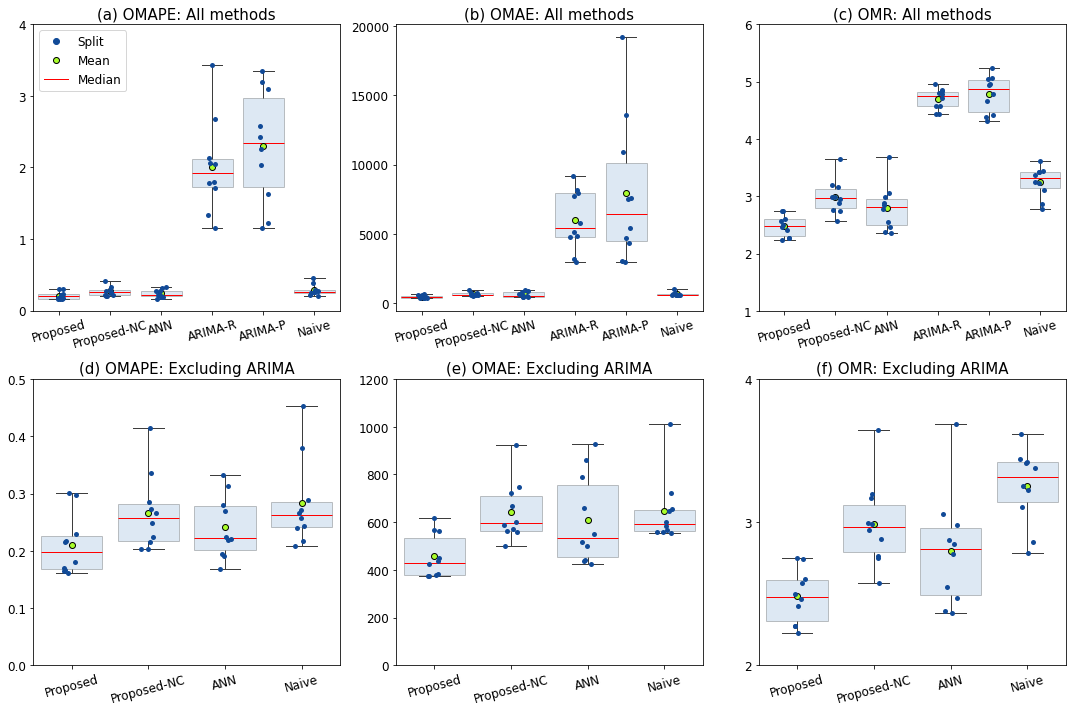

In [5]:
df = pd.read_excel(current_dir+'/Analysis-SA/SA-M/Metrics-200.xlsx', header = 0, sheet_name = 0)
df1 = df[['Proposed_omape', 'ProposedNC_omape', 'ANN_omape', 'ARIMAR_omape', 'ARIMAP_omape', 'Naive_omape']]
df1.columns = ['Proposed', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']
df2 = df[['Proposed_omae', 'ProposedNC_omae', 'ANN_omae', 'ARIMAR_omae', 'ARIMAP_omae', 'Naive_omae']]
df2.columns = ['Proposed', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']
df3 = df[['Proposed_omr','ProposedNC_omr', 'ANN_omr', 'ARIMAR_omr', 'ARIMAP_omr','Naive_omr']]
df3.columns = ['Proposed', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']

f, axes = plt.subplots(2, 3, figsize=(15, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes[0,0], axes[0,1], axes[0,2], axes[1,0], axes[1,1], axes[1,2]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]
ax1 = sns.boxplot(data=df1, ax=ax1, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax2 = sns.boxplot(data=df2, ax=ax2, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax3 = sns.boxplot(data=df3, ax=ax3, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax4 = sns.boxplot(data=df1[['Proposed', 'Proposed-NC', 'ANN', 'Naive']], ax=ax4, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red')
                  , showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax5 = sns.boxplot(data=df2[['Proposed', 'Proposed-NC', 'ANN', 'Naive']], ax=ax5, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red')
                  , showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax6 = sns.boxplot(data=df3[['Proposed', 'Proposed-NC', 'ANN', 'Naive']], ax=ax6, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red')
                  , showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
sns.stripplot(data=df1, ax=ax1, color='#114A97')
sns.stripplot(data=df2, ax=ax2, color='#114A97')
sns.stripplot(data=df3, ax=ax3, color='#114A97')
sns.stripplot(data=df1[['Proposed', 'Proposed-NC', 'ANN', 'Naive']], ax=ax4, color='#114A97')
sns.stripplot(data=df2[['Proposed', 'Proposed-NC', 'ANN', 'Naive']], ax=ax5, color='#114A97')
sns.stripplot(data=df3[['Proposed', 'Proposed-NC', 'ANN', 'Naive']], ax=ax6, color='#114A97')
ax1.set_title('(a) OMAPE: All methods', size=15)
ax2.set_title('(b) OMAE: All methods', size=15) 
ax3.set_title('(c) OMR: All methods', size=15)
ax4.set_title('(d) OMAPE: Excluding ARIMA', size=15)
ax5.set_title('(e) OMAE: Excluding ARIMA', size=15)
ax6.set_title('(f) OMR: Excluding ARIMA', size=15)
ax1.set_yticks(np.linspace(0, 4, 5))
ax2.set_yticks(np.linspace(0, 20000, 5))
ax3.set_yticks(np.linspace(1, 6, 6))
ax4.set_yticks(np.linspace(0, 0.5, 6))
ax5.set_yticks(np.linspace(0, 1200, 7))
ax6.set_yticks(np.linspace(2, 4, 3))
for ax in axes_list:
    ax.tick_params(axis='x', rotation=15)
    ax.tick_params(axis='both', which='major', labelsize=12)

legend_elements = [Line2D([], [], color='#114A97', marker='o', linestyle='', label='Split'),
                   Line2D([], [], color='#A9FD2B', marker='o', markeredgecolor='black', linestyle='', label='Mean'),
                   Line2D([0], [0], color='red', lw=1, label='Median')]
ax1.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Figure_8.png')

#### Figure 9

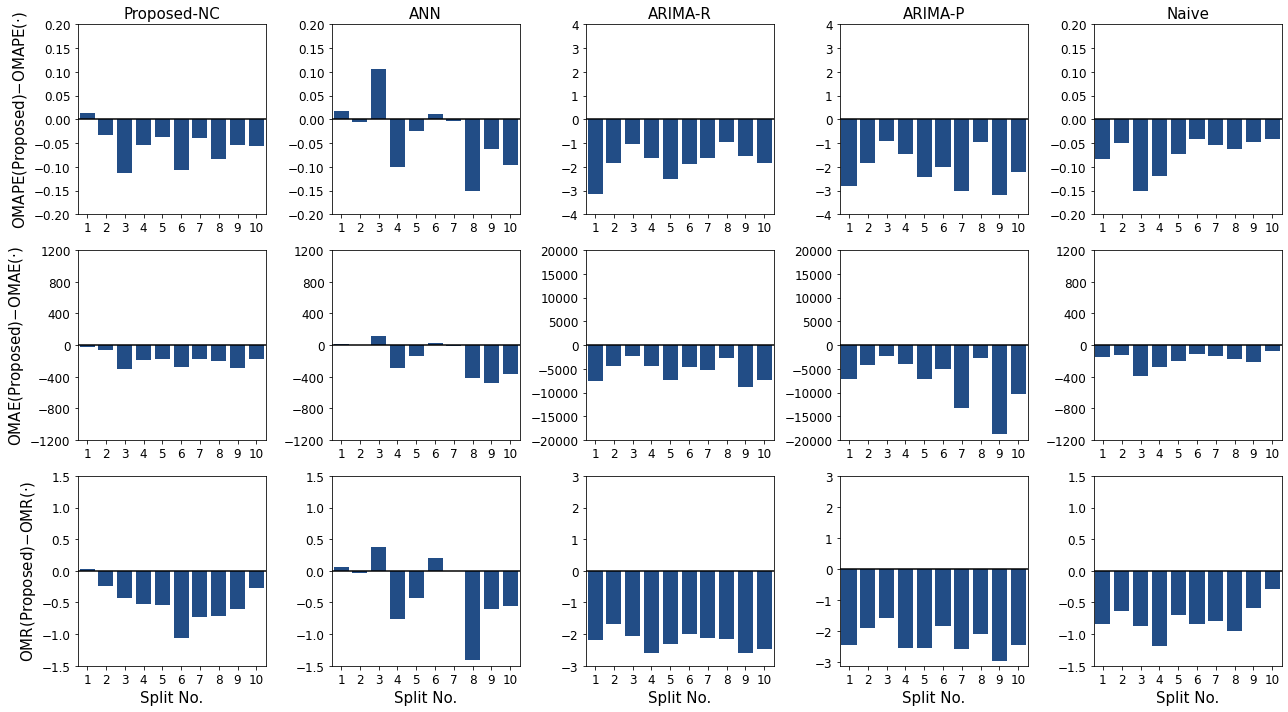

In [6]:
df = pd.read_excel(current_dir+'/Analysis-SA/SA-M/Metrics-200.xlsx', header = 0, sheet_name = 0)

df1 = df[['Proposed_omape', 'ProposedNC_omape', 'ANN_omape', 'ARIMAR_omape', 'ARIMAP_omape', 'Naive_omape']]
df1['Proposed-NC'] = df1['Proposed_omape'] - df1['ProposedNC_omape']
df1['ANN'] = df1['Proposed_omape'] - df1['ANN_omape']
df1['ARIMA-R'] = df1['Proposed_omape'] - df1['ARIMAR_omape']
df1['ARIMA-P'] = df1['Proposed_omape'] - df1['ARIMAP_omape']
df1['Naive'] = df1['Proposed_omape'] - df1['Naive_omape']
df1 = df1[['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]

df2 = df[['Proposed_omae', 'ProposedNC_omae', 'ANN_omae', 'ARIMAR_omae', 'ARIMAP_omae', 'Naive_omae']]
df2['Proposed-NC'] = df2['Proposed_omae'] - df2['ProposedNC_omae']
df2['ANN'] = df2['Proposed_omae'] - df2['ANN_omae']
df2['ARIMA-R'] = df2['Proposed_omae'] - df2['ARIMAR_omae']
df2['ARIMA-P'] = df2['Proposed_omae'] - df2['ARIMAP_omae']
df2['Naive'] = df2['Proposed_omae'] - df2['Naive_omae']
df2 = df2[['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]

df3 = df[['Proposed_omr','ProposedNC_omr', 'ANN_omr', 'ARIMAR_omr', 'ARIMAP_omr','Naive_omr']]
df3['Proposed-NC'] = df3['Proposed_omr'] - df3['ProposedNC_omr']
df3['ANN'] = df3['Proposed_omr'] - df3['ANN_omr']
df3['ARIMA-R'] = df3['Proposed_omr'] - df3['ARIMAR_omr']
df3['ARIMA-P'] = df3['Proposed_omr'] - df3['ARIMAP_omr']
df3['Naive'] = df3['Proposed_omr'] - df3['Naive_omr']
df3 = df3[['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]

f, axes = plt.subplots(3, 5, figsize=(18, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
ax11, ax12, ax13, ax14, ax15 = axes[2,0], axes[2,1], axes[2,2], axes[2,3], axes[2,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]

ax1 = sns.barplot(x=df1.index+1, y=df1['Proposed-NC'].T, ax=ax1, color='#114A97')
ax2 = sns.barplot(x=df1.index+1, y=df1['ANN'].T, ax=ax2, color='#114A97')
ax3 = sns.barplot(x=df1.index+1, y=df1['ARIMA-R'].T, ax=ax3, color='#114A97')
ax4 = sns.barplot(x=df1.index+1, y=df1['ARIMA-P'].T, ax=ax4, color='#114A97')
ax5 = sns.barplot(x=df1.index+1, y=df1['Naive'].T, ax=ax5, color='#114A97')
ax6 = sns.barplot(x=df2.index+1, y=df2['Proposed-NC'].T, ax=ax6, color='#114A97')
ax7 = sns.barplot(x=df2.index+1, y=df2['ANN'].T, ax=ax7, color='#114A97')
ax8 = sns.barplot(x=df2.index+1, y=df2['ARIMA-R'].T, ax=ax8, color='#114A97')
ax9 = sns.barplot(x=df2.index+1, y=df2['ARIMA-P'].T, ax=ax9, color='#114A97')
ax10 = sns.barplot(x=df2.index+1, y=df2['Naive'].T, ax=ax10, color='#114A97')
ax11 = sns.barplot(x=df3.index+1, y=df3['Proposed-NC'].T, ax=ax11, color='#114A97')
ax12 = sns.barplot(x=df3.index+1, y=df3['ANN'].T, ax=ax12, color='#114A97')
ax13 = sns.barplot(x=df3.index+1, y=df3['ARIMA-R'].T, ax=ax13, color='#114A97')
ax14 = sns.barplot(x=df3.index+1, y=df3['ARIMA-P'].T, ax=ax14, color='#114A97')
ax15 = sns.barplot(x=df3.index+1, y=df3['Naive'].T, ax=ax15, color='#114A97')
for ax in axes_list:
    ax.hlines(0, -0.5, 9.5, color='black')
    ax.set_xlim(-0.5, 9.5)

for ax in axes_list:
    ax.set_xlabel('')
    ax.set_ylabel('')
ax1.set_ylabel('OMAPE(Proposed)$-$OMAPE(·)', size=15)
ax6.set_ylabel('OMAE(Proposed)$-$OMAE(·)', size=15)
ax11.set_ylabel('OMR(Proposed)$-$OMR(·)', size=15)
ax11.set_xlabel('Split No.', size=15)
ax12.set_xlabel('Split No.', size=15)
ax13.set_xlabel('Split No.', size=15)
ax14.set_xlabel('Split No.', size=15)
ax15.set_xlabel('Split No.', size=15)
ax1.set_title('Proposed-NC', size=15)
ax2.set_title('ANN', size=15)
ax3.set_title('ARIMA-R', size=15)
ax4.set_title('ARIMA-P', size=15)
ax5.set_title('Naive', size=15)

ax1.set_yticks(np.linspace(-0.2, 0.2, 9))
ax2.set_yticks(np.linspace(-0.2, 0.2, 9))
ax5.set_yticks(np.linspace(-0.2, 0.2, 9))
ax6.set_yticks(np.linspace(-1200, 1200, 7))
ax7.set_yticks(np.linspace(-1200, 1200, 7))
ax10.set_yticks(np.linspace(-1200, 1200, 7))
ax11.set_yticks(np.linspace(-1.5, 1.5, 7))
ax12.set_yticks(np.linspace(-1.5, 1.5, 7))
ax15.set_yticks(np.linspace(-1.5, 1.5, 7))
ax3.set_yticks(np.linspace(-4, 4, 9))
ax4.set_yticks(np.linspace(-4, 4, 9))
ax8.set_yticks(np.linspace(-20000, 20000, 9))
ax9.set_yticks(np.linspace(-20000, 20000, 9))
ax13.set_yticks(np.linspace(-3, 3, 7))
ax14.set_yticks(np.linspace(-3, 3, 7))
for ax in axes_list:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Figure_9.png')

#### Figure 10

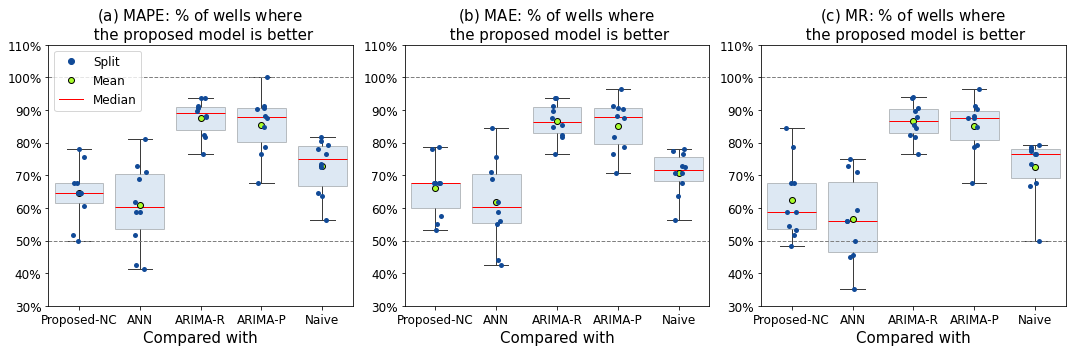

In [7]:
path = current_dir+'/Analysis-SA/SA-M/M'+str(200)+'/'
proposed_mape_better_proposednc, proposed_mape_better_ann, proposed_mape_better_arimar, proposed_mape_better_arimap, proposed_mape_better_naive = [], [], [], [], []
proposed_mae_better_proposednc, proposed_mae_better_ann, proposed_mae_better_arimar, proposed_mae_better_arimap, proposed_mae_better_naive = [], [], [], [], []
proposed_mr_better_proposednc, proposed_mr_better_ann, proposed_mr_better_arimar, proposed_mr_better_arimap, proposed_mr_better_naive = [], [], [], [], []
for rs in split_rs:
    df = pd.read_excel(path+'Metrics-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    count_proposed_mape_better_proposednc, count_proposed_mape_better_ann, count_proposed_mape_better_arimar, count_proposed_mape_better_arimap, count_proposed_mape_better_naive = 0, 0, 0, 0, 0
    count_proposed_mae_better_proposednc, count_proposed_mae_better_ann, count_proposed_mae_better_arimar, count_proposed_mae_better_arimap, count_proposed_mae_better_naive = 0, 0, 0, 0, 0
    count_proposed_mr_better_proposednc, count_proposed_mr_better_ann, count_proposed_mr_better_arimar, count_proposed_mr_better_arimap, count_proposed_mr_better_naive = 0, 0, 0, 0, 0
    for j in range(len(df)):
        if df['Proposed_mape'][j] - df['ProposedNC_mape'][j] < 0:
            count_proposed_mape_better_proposednc += 1
        if df['Proposed_mape'][j] - df['ANN_mape'][j] < 0:
            count_proposed_mape_better_ann += 1
        if df['Proposed_mape'][j] - df['ARIMAR_mape'][j] < 0:
            count_proposed_mape_better_arimar += 1
        if df['Proposed_mape'][j] - df['ARIMAP_mape'][j] < 0:
            count_proposed_mape_better_arimap += 1
        if df['Proposed_mape'][j] - df['Naive_mape'][j] < 0:
            count_proposed_mape_better_naive += 1
        if df['Proposed_mae'][j] - df['ProposedNC_mae'][j] < 0:
            count_proposed_mae_better_proposednc += 1
        if df['Proposed_mae'][j] - df['ANN_mae'][j] < 0:
            count_proposed_mae_better_ann += 1
        if df['Proposed_mae'][j] - df['ARIMAR_mae'][j] < 0:
            count_proposed_mae_better_arimar += 1
        if df['Proposed_mae'][j] - df['ARIMAP_mae'][j] < 0:
            count_proposed_mae_better_arimap += 1
        if df['Proposed_mae'][j] - df['Naive_mae'][j] < 0:
            count_proposed_mae_better_naive += 1
        if df['Proposed_mr'][j] - df['ProposedNC_mr'][j] < 0:
            count_proposed_mr_better_proposednc += 1
        if df['Proposed_mr'][j] - df['ANN_mr'][j] < 0:
            count_proposed_mr_better_ann += 1
        if df['Proposed_mr'][j] - df['ARIMAR_mr'][j] < 0:
            count_proposed_mr_better_arimar += 1
        if df['Proposed_mr'][j] - df['ARIMAP_mr'][j] < 0:
            count_proposed_mr_better_arimap += 1
        if df['Proposed_mr'][j] - df['Naive_mr'][j] < 0:
            count_proposed_mr_better_naive += 1
    proposed_mape_better_proposednc.append(count_proposed_mape_better_proposednc/len(df))
    proposed_mape_better_ann.append(count_proposed_mape_better_ann/len(df))
    proposed_mape_better_arimar.append(count_proposed_mape_better_arimar/len(df))
    proposed_mape_better_arimap.append(count_proposed_mape_better_arimap/len(df))
    proposed_mape_better_naive.append(count_proposed_mape_better_naive/len(df))
    proposed_mae_better_proposednc.append(count_proposed_mae_better_proposednc/len(df))
    proposed_mae_better_ann.append(count_proposed_mae_better_ann/len(df))
    proposed_mae_better_arimar.append(count_proposed_mae_better_arimar/len(df))
    proposed_mae_better_arimap.append(count_proposed_mae_better_arimap/len(df))
    proposed_mae_better_naive.append(count_proposed_mae_better_naive/len(df))
    proposed_mr_better_proposednc.append(count_proposed_mr_better_proposednc/len(df))
    proposed_mr_better_ann.append(count_proposed_mr_better_ann/len(df))
    proposed_mr_better_arimar.append(count_proposed_mr_better_arimar/len(df))
    proposed_mr_better_arimap.append(count_proposed_mr_better_arimap/len(df))
    proposed_mr_better_naive.append(count_proposed_mr_better_naive/len(df))

df1 = pd.DataFrame({'Proposed-NC': proposed_mape_better_proposednc,
                    'ANN': proposed_mape_better_ann,
                    'ARIMA-R': proposed_mape_better_arimar,
                    'ARIMA-P': proposed_mape_better_arimap,
                    'Naive': proposed_mape_better_naive})
df2 = pd.DataFrame({'Proposed-NC': proposed_mae_better_proposednc,
                    'ANN': proposed_mae_better_ann,
                    'ARIMA-R': proposed_mae_better_arimar,
                    'ARIMA-P': proposed_mae_better_arimap,
                    'Naive': proposed_mae_better_naive})
df3 = pd.DataFrame({'Proposed-NC': proposed_mr_better_proposednc,
                    'ANN': proposed_mr_better_ann,
                    'ARIMA-R': proposed_mr_better_arimar,
                    'ARIMA-P': proposed_mr_better_arimap,
                    'Naive': proposed_mr_better_naive})
df1 = df1 * 100
df2 = df2 * 100
df3 = df3 * 100

f, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
axes_list = [ax1, ax2, ax3]
ax1 = sns.boxplot(data=df1, ax=ax1, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax2 = sns.boxplot(data=df2, ax=ax2, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax3 = sns.boxplot(data=df3, ax=ax3, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
sns.stripplot(data=df1, ax=ax1, color='#114A97')
sns.stripplot(data=df2, ax=ax2, color='#114A97')
sns.stripplot(data=df3, ax=ax3, color='#114A97')
ax1.set_title('(a) MAPE: $\%$ of wells where \n the proposed model is better', size=15)
ax2.set_title('(b) MAE: $\%$ of wells where \n the proposed model is better', size=15) 
ax3.set_title('(c) MR: $\%$ of wells where \n the proposed model is better', size=15)
for ax in axes_list:
    ax.set_xlim(-0.5, 4.5)
    ax.hlines(50, -0.5, 4.5, color='grey', linewidth=1, linestyle='--')
    ax.hlines(100, -0.5, 4.5, color='grey', linewidth=1, linestyle='--')
    ax.set_xlabel('Compared with', size=15)
    ax.set_ylim(30, 110)
    ax.set_yticks(np.linspace(30, 110, 9))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

legend_elements = [Line2D([], [], color='#114A97', marker='o', linestyle='', label='Split'),
                   Line2D([], [], color='#A9FD2B', marker='o', markeredgecolor='black', linestyle='', label='Mean'),
                   Line2D([0], [0], color='red', lw=1, label='Median')]
ax1.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Figure_10.png')

### Figures for the sensitivity analysis of $M$ and $w_3$ (Section 3.3)

#### Figure 11

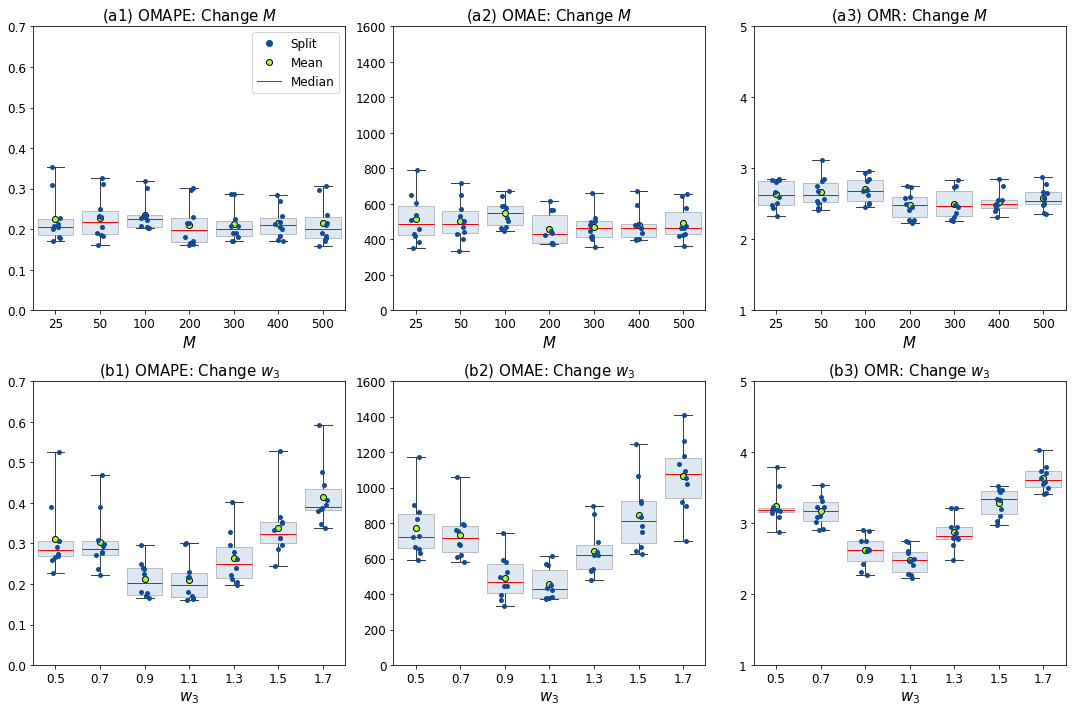

In [8]:
df1, df2, df3 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for this_m in all_ms:
    df = pd.read_excel(current_dir+'/Analysis-SA/SA-M/Metrics-'+str(this_m)+'.xlsx', header = 0, sheet_name = 0)
    df1[str(this_m)] = df['Proposed_omape']
    df2[str(this_m)] = df['Proposed_omae']
    df3[str(this_m)] = df['Proposed_omr']

df4, df5, df6 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for this_w3 in all_w3s:
    df = pd.read_excel(current_dir+'/Analysis-SA/SA-w3/Metrics-'+str(this_w3)+'.xlsx', header = 0, sheet_name = 0)
    df4[str(this_w3)] = df['Proposed_omape']
    df5[str(this_w3)] = df['Proposed_omae']
    df6[str(this_w3)] = df['Proposed_omr']

f, axes = plt.subplots(2, 3, figsize=(15, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes[0,0], axes[0,1], axes[0,2], axes[1,0], axes[1,1], axes[1,2]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]
ax1 = sns.boxplot(data=df1, ax=ax1, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax2 = sns.boxplot(data=df2, ax=ax2, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax3 = sns.boxplot(data=df3, ax=ax3, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax4 = sns.boxplot(data=df4, ax=ax4, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax5 = sns.boxplot(data=df5, ax=ax5, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
ax6 = sns.boxplot(data=df6, ax=ax6, boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
sns.stripplot(data=df1, ax=ax1, color='#114A97')
sns.stripplot(data=df2, ax=ax2, color='#114A97')
sns.stripplot(data=df3, ax=ax3, color='#114A97')
sns.stripplot(data=df4, ax=ax4, color='#114A97')
sns.stripplot(data=df5, ax=ax5, color='#114A97')
sns.stripplot(data=df6, ax=ax6, color='#114A97')
ax1.set_title('(a1) OMAPE: Change $M$', size=15)
ax2.set_title('(a2) OMAE: Change $M$', size=15) 
ax3.set_title('(a3) OMR: Change $M$', size=15)
ax4.set_title('(b1) OMAPE: Change $w_3$', size=15)
ax5.set_title('(b2) OMAE: Change $w_3$', size=15)
ax6.set_title('(b3) OMR: Change $w_3$', size=15)
ax1.set_xlabel('$M$', size=15)
ax2.set_xlabel('$M$', size=15) 
ax3.set_xlabel('$M$', size=15)
ax4.set_xlabel('$w_3$', size=15)
ax5.set_xlabel('$w_3$', size=15)
ax6.set_xlabel('$w_3$', size=15)
ax1.set_yticks(np.linspace(0, 0.7, 8))
ax2.set_yticks(np.linspace(0, 1600, 9))
ax3.set_yticks(np.linspace(1, 5, 5))
ax4.set_yticks(np.linspace(0, 0.7, 8))
ax5.set_yticks(np.linspace(0, 1600, 9))
ax6.set_yticks(np.linspace(1, 5, 5))
for ax in axes_list:
    ax.tick_params(axis='both', which='major', labelsize=12)

legend_elements = [Line2D([], [], color='#114A97', marker='o', linestyle='', label='Split'),
                   Line2D([], [], color='#A9FD2B', marker='o', markeredgecolor='black', linestyle='', label='Mean'),
                   Line2D([0], [0], color='red', lw=1, label='Median')]
ax1.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Figure_11.png')

#### Supp. figures 1 and 2 

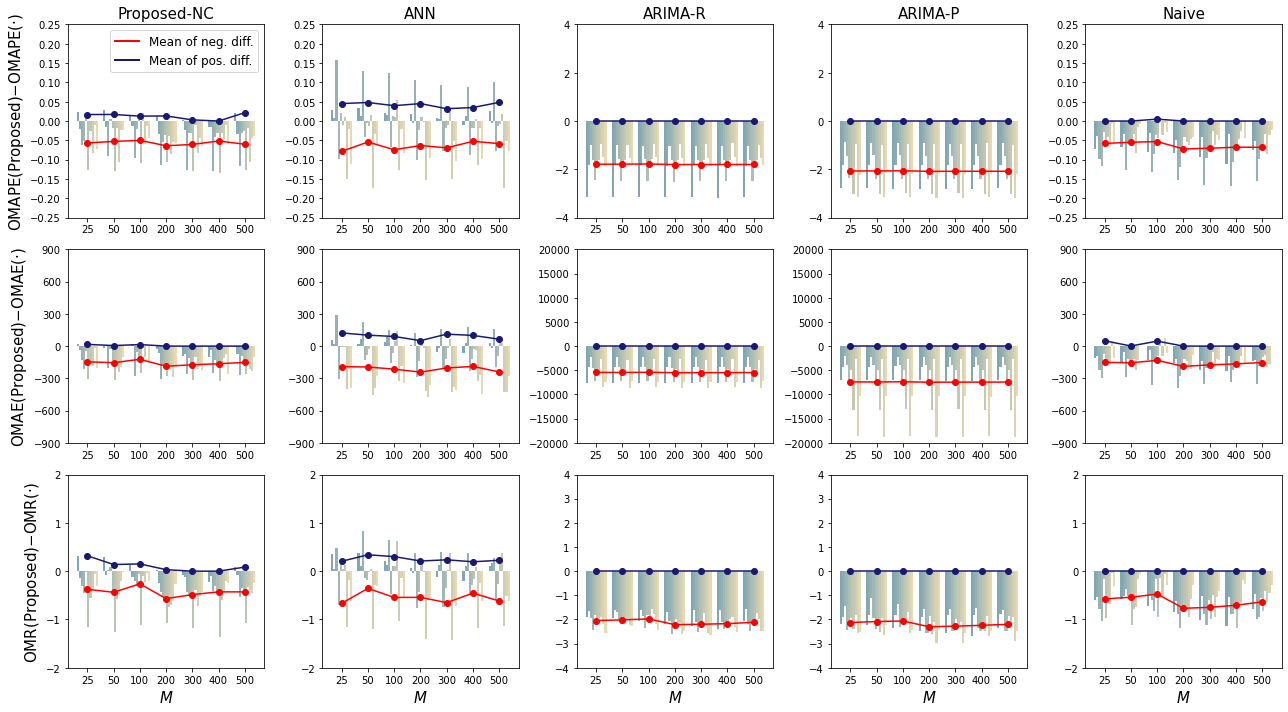

In [9]:
df1_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])
df2_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])
df3_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])

for this_m in all_ms:

    df = pd.read_excel(current_dir+'/Analysis-SA/SA-M/Metrics-'+str(this_m)+'.xlsx', header = 0, sheet_name = 0)

    df1 = df[['Proposed_omape', 'ProposedNC_omape', 'ANN_omape', 'ARIMAR_omape', 'ARIMAP_omape', 'Naive_omape']]
    df1['Proposed-NC'] = df1['Proposed_omape'] - df1['ProposedNC_omape']
    df1['ANN'] = df1['Proposed_omape'] - df1['ANN_omape']
    df1['ARIMA-R'] = df1['Proposed_omape'] - df1['ARIMAR_omape']
    df1['ARIMA-P'] = df1['Proposed_omape'] - df1['ARIMAP_omape']
    df1['Naive'] = df1['Proposed_omape'] - df1['Naive_omape']
    df1 = df1[['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]
    df1_total = pd.concat((df1_total, df1))

    df2 = df[['Proposed_omae', 'ProposedNC_omae', 'ANN_omae', 'ARIMAR_omae', 'ARIMAP_omae', 'Naive_omae']]
    df2['Proposed-NC'] = df2['Proposed_omae'] - df2['ProposedNC_omae']
    df2['ANN'] = df2['Proposed_omae'] - df2['ANN_omae']
    df2['ARIMA-R'] = df2['Proposed_omae'] - df2['ARIMAR_omae']
    df2['ARIMA-P'] = df2['Proposed_omae'] - df2['ARIMAP_omae']
    df2['Naive'] = df2['Proposed_omae'] - df2['Naive_omae']
    df2 = df2[['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]
    df2_total = pd.concat((df2_total, df2))

    df3 = df[['Proposed_omr','ProposedNC_omr', 'ANN_omr', 'ARIMAR_omr', 'ARIMAP_omr','Naive_omr']]
    df3['Proposed-NC'] = df3['Proposed_omr'] - df3['ProposedNC_omr']
    df3['ANN'] = df3['Proposed_omr'] - df3['ANN_omr']
    df3['ARIMA-R'] = df3['Proposed_omr'] - df3['ARIMAR_omr']
    df3['ARIMA-P'] = df3['Proposed_omr'] - df3['ARIMAP_omr']
    df3['Naive'] = df3['Proposed_omr'] - df3['Naive_omr']
    df3 = df3[['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]
    df3_total = pd.concat((df3_total, df3))

df1_total = df1_total.reset_index(drop=True)
df2_total = df2_total.reset_index(drop=True)
df3_total = df3_total.reset_index(drop=True)

f, axes = plt.subplots(3, 5, figsize=(18, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
ax11, ax12, ax13, ax14, ax15 = axes[2,0], axes[2,1], axes[2,2], axes[2,3], axes[2,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]

for k in range(len(df1_total.columns)):
    df = pd.DataFrame(df1_total[df1_total.columns[k]])
    split_no = []
    m_values = []
    for i in range(len(all_ms)):
        for j in range(1,11):
            split_no.append(j)
            m_values.append(all_ms[i])
    df['Split'] = split_no
    df['M'] = m_values
    pos_mean = df[df[df1_total.columns[k]]>=0].groupby('M')[df1_total.columns[k]].mean().reset_index()
    neg_mean = df[df[df1_total.columns[k]]<0].groupby('M')[df1_total.columns[k]].mean().reset_index()
    merged = pd.merge(pos_mean, neg_mean, on='M', how='outer').fillna(0).sort_values(by='M').reset_index(drop=True)

    axes_list[k] = sns.barplot(data=df, x='M', y=df1_total.columns[k], hue='Split', palette=sns.color_palette('blend:#7AB,#EDA', as_cmap=True), ax=axes_list[k])
    axes_list[k].plot(merged.index, merged[df1_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k].plot(merged.index, merged[df1_total.columns[k]+'_y'], color='red')
    axes_list[k].scatter(merged.index, merged[df1_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k].scatter(merged.index, merged[df1_total.columns[k]+'_y'], color='red')
    axes_list[k].legend_.remove()

for k in range(len(df2_total.columns)):
    df = pd.DataFrame(df2_total[df2_total.columns[k]])
    split_no = []
    m_values = []
    for i in range(len(all_ms)):
        for j in range(1,11):
            split_no.append(j)
            m_values.append(all_ms[i])
    df['Split'] = split_no
    df['M'] = m_values
    pos_mean = df[df[df2_total.columns[k]]>=0].groupby('M')[df2_total.columns[k]].mean().reset_index()
    neg_mean = df[df[df2_total.columns[k]]<0].groupby('M')[df2_total.columns[k]].mean().reset_index()
    merged = pd.merge(pos_mean, neg_mean, on='M', how='outer').fillna(0).sort_values(by='M').reset_index(drop=True)

    axes_list[k+5] = sns.barplot(data=df, x='M', y=df2_total.columns[k], hue='Split', palette=sns.color_palette('blend:#7AB,#EDA', as_cmap=True), ax=axes_list[k+5])
    axes_list[k+5].plot(merged.index, merged[df2_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k+5].plot(merged.index, merged[df2_total.columns[k]+'_y'], color='red')
    axes_list[k+5].scatter(merged.index, merged[df2_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k+5].scatter(merged.index, merged[df2_total.columns[k]+'_y'], color='red')
    axes_list[k+5].legend_.remove()

for k in range(len(df3_total.columns)):
    df = pd.DataFrame(df3_total[df3_total.columns[k]])
    split_no = []
    m_values = []
    for i in range(len(all_ms)):
        for j in range(1,11):
            split_no.append(j)
            m_values.append(all_ms[i])
    df['Split'] = split_no
    df['M'] = m_values
    pos_mean = df[df[df3_total.columns[k]]>=0].groupby('M')[df3_total.columns[k]].mean().reset_index()
    neg_mean = df[df[df3_total.columns[k]]<0].groupby('M')[df3_total.columns[k]].mean().reset_index()
    merged = pd.merge(pos_mean, neg_mean, on='M', how='outer').fillna(0).sort_values(by='M').reset_index(drop=True)
    
    axes_list[k+10] = sns.barplot(data=df, x='M', y=df3_total.columns[k], hue='Split', palette=sns.color_palette('blend:#7AB,#EDA', as_cmap=True), ax=axes_list[k+10])
    axes_list[k+10].plot(merged.index, merged[df3_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k+10].plot(merged.index, merged[df3_total.columns[k]+'_y'], color='red')
    axes_list[k+10].scatter(merged.index, merged[df3_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k+10].scatter(merged.index, merged[df3_total.columns[k]+'_y'], color='red')
    axes_list[k+10].legend_.remove()

for ax in axes_list:
    ax.set_xlabel('')
    ax.set_ylabel('')
ax1.set_ylabel('OMAPE(Proposed)$-$OMAPE(·)', size=15)
ax6.set_ylabel('OMAE(Proposed)$-$OMAE(·)', size=15)
ax11.set_ylabel('OMR(Proposed)$-$OMR(·)', size=15)
ax11.set_xlabel('$M$', size=15)
ax12.set_xlabel('$M$', size=15)
ax13.set_xlabel('$M$', size=15)
ax14.set_xlabel('$M$', size=15)
ax15.set_xlabel('$M$', size=15)
ax1.set_title('Proposed-NC', size=15)
ax2.set_title('ANN', size=15)
ax3.set_title('ARIMA-R', size=15)
ax4.set_title('ARIMA-P', size=15)
ax5.set_title('Naive', size=15)

ax1.set_yticks(np.linspace(-0.25, 0.25, 11))
ax2.set_yticks(np.linspace(-0.25, 0.25, 11))
ax5.set_yticks(np.linspace(-0.25, 0.25, 11))
ax6.set_yticks(np.linspace(-900, 900, 7))
ax7.set_yticks(np.linspace(-900, 900, 7))
ax10.set_yticks(np.linspace(-900, 900, 7))
ax11.set_yticks(np.linspace(-2, 2, 5))
ax12.set_yticks(np.linspace(-2, 2, 5))
ax15.set_yticks(np.linspace(-2, 2, 5))
ax3.set_yticks(np.linspace(-4, 4, 5))
ax4.set_yticks(np.linspace(-4, 4, 5))
ax8.set_yticks(np.linspace(-20000, 20000, 9))
ax9.set_yticks(np.linspace(-20000, 20000, 9))
ax13.set_yticks(np.linspace(-4, 4, 9))
ax14.set_yticks(np.linspace(-4, 4, 9))

legend_elements = [Line2D([0], [0], color='red', lw=2, label='Mean of neg. diff.'),
                   Line2D([0], [0], color='midnightblue', lw=2, label='Mean of pos. diff.')]
ax1.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_1.png')

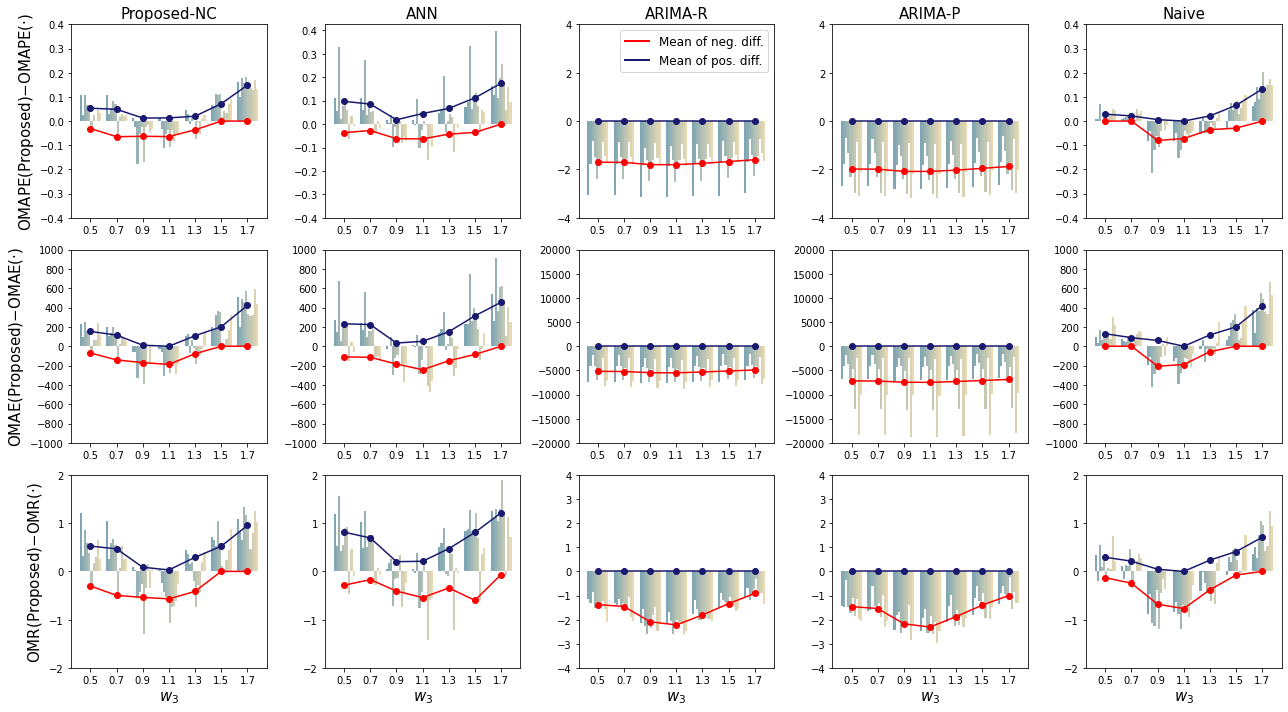

In [10]:
df1_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])
df2_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])
df3_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])

for this_w3 in all_w3s:

    df = pd.read_excel(current_dir+'/Analysis-SA/SA-w3/Metrics-'+str(this_w3)+'.xlsx', header = 0, sheet_name = 0)

    df1 = df[['Proposed_omape', 'ProposedNC_omape', 'ANN_omape', 'ARIMAR_omape', 'ARIMAP_omape', 'Naive_omape']]
    df1['Proposed-NC'] = df1['Proposed_omape'] - df1['ProposedNC_omape']
    df1['ANN'] = df1['Proposed_omape'] - df1['ANN_omape']
    df1['ARIMA-R'] = df1['Proposed_omape'] - df1['ARIMAR_omape']
    df1['ARIMA-P'] = df1['Proposed_omape'] - df1['ARIMAP_omape']
    df1['Naive'] = df1['Proposed_omape'] - df1['Naive_omape']
    df1 = df1[['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]
    df1_total = pd.concat((df1_total, df1))

    df2 = df[['Proposed_omae', 'ProposedNC_omae', 'ANN_omae', 'ARIMAR_omae', 'ARIMAP_omae', 'Naive_omae']]
    df2['Proposed-NC'] = df2['Proposed_omae'] - df2['ProposedNC_omae']
    df2['ANN'] = df2['Proposed_omae'] - df2['ANN_omae']
    df2['ARIMA-R'] = df2['Proposed_omae'] - df2['ARIMAR_omae']
    df2['ARIMA-P'] = df2['Proposed_omae'] - df2['ARIMAP_omae']
    df2['Naive'] = df2['Proposed_omae'] - df2['Naive_omae']
    df2 = df2[['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]
    df2_total = pd.concat((df2_total, df2))

    df3 = df[['Proposed_omr','ProposedNC_omr', 'ANN_omr', 'ARIMAR_omr', 'ARIMAP_omr','Naive_omr']]
    df3['Proposed-NC'] = df3['Proposed_omr'] - df3['ProposedNC_omr']
    df3['ANN'] = df3['Proposed_omr'] - df3['ANN_omr']
    df3['ARIMA-R'] = df3['Proposed_omr'] - df3['ARIMAR_omr']
    df3['ARIMA-P'] = df3['Proposed_omr'] - df3['ARIMAP_omr']
    df3['Naive'] = df3['Proposed_omr'] - df3['Naive_omr']
    df3 = df3[['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]
    df3_total = pd.concat((df3_total, df3))

df1_total = df1_total.reset_index(drop=True)
df2_total = df2_total.reset_index(drop=True)
df3_total = df3_total.reset_index(drop=True)

# 画图
f, axes = plt.subplots(3, 5, figsize=(18, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
ax11, ax12, ax13, ax14, ax15 = axes[2,0], axes[2,1], axes[2,2], axes[2,3], axes[2,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]

for k in range(len(df1_total.columns)):
    df = pd.DataFrame(df1_total[df1_total.columns[k]])
    split_no = []
    w3_values = []
    for i in range(len(all_w3s)):
        for j in range(1,11):
            split_no.append(j)
            w3_values.append(all_w3s[i])
    df['Split'] = split_no
    df['w3'] = w3_values
    pos_mean = df[df[df1_total.columns[k]]>=0].groupby('w3')[df1_total.columns[k]].mean().reset_index()
    neg_mean = df[df[df1_total.columns[k]]<0].groupby('w3')[df1_total.columns[k]].mean().reset_index()
    merged = pd.merge(pos_mean, neg_mean, on='w3', how='outer').fillna(0).sort_values(by='w3').reset_index(drop=True)

    axes_list[k] = sns.barplot(data=df, x='w3', y=df1_total.columns[k], hue='Split', palette=sns.color_palette('blend:#7AB,#EDA', as_cmap=True), ax=axes_list[k])
    axes_list[k].plot(merged.index, merged[df1_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k].plot(merged.index, merged[df1_total.columns[k]+'_y'], color='red')
    axes_list[k].scatter(merged.index, merged[df1_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k].scatter(merged.index, merged[df1_total.columns[k]+'_y'], color='red')
    axes_list[k].legend_.remove()

for k in range(len(df2_total.columns)):
    df = pd.DataFrame(df2_total[df2_total.columns[k]])
    split_no = []
    w3_values = []
    for i in range(len(all_w3s)):
        for j in range(1,11):
            split_no.append(j)
            w3_values.append(all_w3s[i])
    df['Split'] = split_no
    df['w3'] = w3_values
    pos_mean = df[df[df2_total.columns[k]]>=0].groupby('w3')[df2_total.columns[k]].mean().reset_index()
    neg_mean = df[df[df2_total.columns[k]]<0].groupby('w3')[df2_total.columns[k]].mean().reset_index()
    merged = pd.merge(pos_mean, neg_mean, on='w3', how='outer').fillna(0).sort_values(by='w3').reset_index(drop=True)

    axes_list[k+5] = sns.barplot(data=df, x='w3', y=df2_total.columns[k], hue='Split', palette=sns.color_palette('blend:#7AB,#EDA', as_cmap=True), ax=axes_list[k+5])
    axes_list[k+5].plot(merged.index, merged[df2_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k+5].plot(merged.index, merged[df2_total.columns[k]+'_y'], color='red')
    axes_list[k+5].scatter(merged.index, merged[df2_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k+5].scatter(merged.index, merged[df2_total.columns[k]+'_y'], color='red')
    axes_list[k+5].legend_.remove()

for k in range(len(df3_total.columns)):
    df = pd.DataFrame(df3_total[df3_total.columns[k]])
    split_no = []
    w3_values = []
    for i in range(len(all_w3s)):
        for j in range(1,11):
            split_no.append(j)
            w3_values.append(all_w3s[i])
    df['Split'] = split_no
    df['w3'] = w3_values
    pos_mean = df[df[df3_total.columns[k]]>=0].groupby('w3')[df3_total.columns[k]].mean().reset_index()
    neg_mean = df[df[df3_total.columns[k]]<0].groupby('w3')[df3_total.columns[k]].mean().reset_index()
    merged = pd.merge(pos_mean, neg_mean, on='w3', how='outer').fillna(0).sort_values(by='w3').reset_index(drop=True)

    axes_list[k+10] = sns.barplot(data=df, x='w3', y=df3_total.columns[k], hue='Split', palette=sns.color_palette('blend:#7AB,#EDA', as_cmap=True), ax=axes_list[k+10])
    axes_list[k+10].plot(merged.index, merged[df3_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k+10].plot(merged.index, merged[df3_total.columns[k]+'_y'], color='red')
    axes_list[k+10].scatter(merged.index, merged[df3_total.columns[k]+'_x'], color='midnightblue')
    axes_list[k+10].scatter(merged.index, merged[df3_total.columns[k]+'_y'], color='red')
    axes_list[k+10].legend_.remove()

for ax in axes_list:
    ax.set_xlabel('')
    ax.set_ylabel('')
ax1.set_ylabel('OMAPE(Proposed)$-$OMAPE(·)', size=15)
ax6.set_ylabel('OMAE(Proposed)$-$OMAE(·)', size=15)
ax11.set_ylabel('OMR(Proposed)$-$OMR(·)', size=15)
ax11.set_xlabel('$w_3$', size=15)
ax12.set_xlabel('$w_3$', size=15)
ax13.set_xlabel('$w_3$', size=15)
ax14.set_xlabel('$w_3$', size=15)
ax15.set_xlabel('$w_3$', size=15)
ax1.set_title('Proposed-NC', size=15)
ax2.set_title('ANN', size=15)
ax3.set_title('ARIMA-R', size=15)
ax4.set_title('ARIMA-P', size=15)
ax5.set_title('Naive', size=15)

ax1.set_yticks(np.linspace(-0.4, 0.4, 9))
ax2.set_yticks(np.linspace(-0.4, 0.4, 9))
ax5.set_yticks(np.linspace(-0.4, 0.4, 9))
ax6.set_yticks(np.linspace(-1000, 1000, 11))
ax7.set_yticks(np.linspace(-1000, 1000, 11))
ax10.set_yticks(np.linspace(-1000, 1000, 11))
ax11.set_yticks(np.linspace(-2, 2, 5))
ax12.set_yticks(np.linspace(-2, 2, 5))
ax15.set_yticks(np.linspace(-2, 2, 5))
ax3.set_yticks(np.linspace(-4, 4, 5))
ax4.set_yticks(np.linspace(-4, 4, 5))
ax8.set_yticks(np.linspace(-20000, 20000, 9))
ax9.set_yticks(np.linspace(-20000, 20000, 9))
ax13.set_yticks(np.linspace(-4, 4, 9))
ax14.set_yticks(np.linspace(-4, 4, 9))

ax12.set_ylim(-2,2)

legend_elements = [Line2D([0], [0], color='red', lw=2, label='Mean of neg. diff.'),
                   Line2D([0], [0], color='midnightblue', lw=2, label='Mean of pos. diff.')]
ax3.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_2.png')

#### Supp. figures 3 and 4

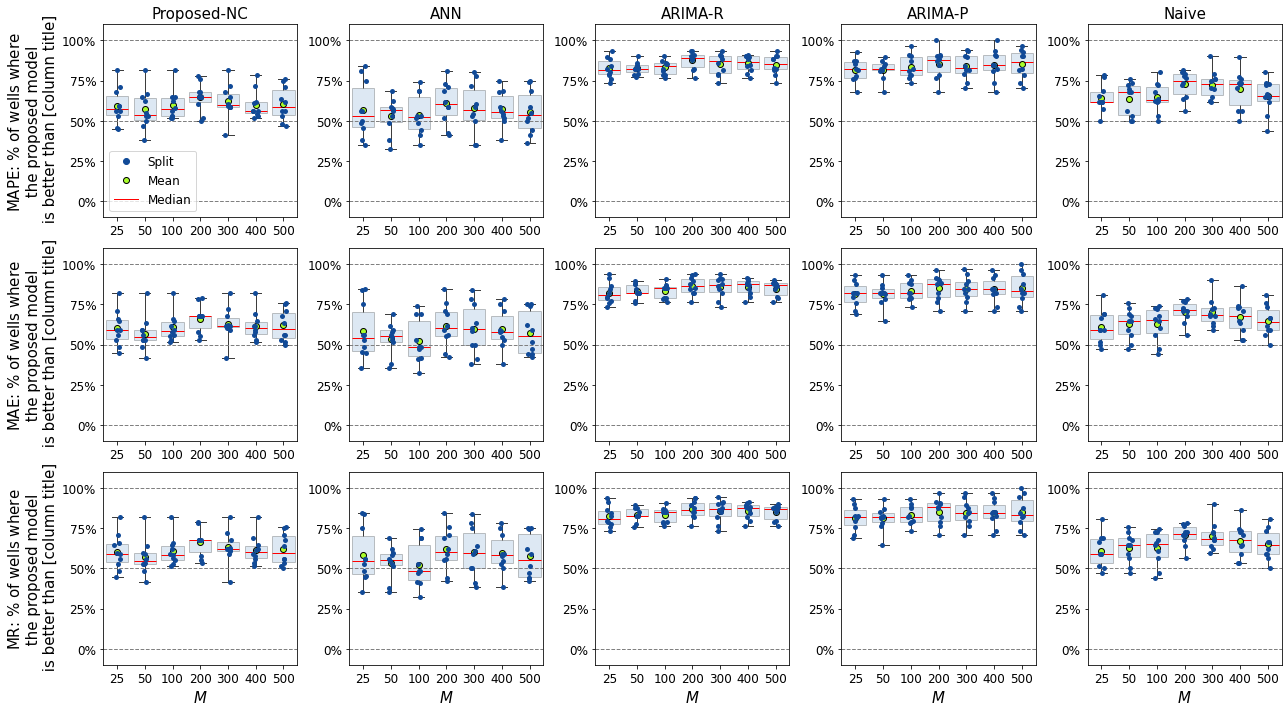

In [11]:
df1_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])
df2_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])
df3_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])

for this_m in all_ms:

    path = current_dir+'/Analysis-SA/SA-M/M'+str(this_m)+'/'
    proposed_mape_better_proposednc, proposed_mape_better_ann, proposed_mape_better_arimar, proposed_mape_better_arimap, proposed_mape_better_naive = [], [], [], [], []
    proposed_mae_better_proposednc, proposed_mae_better_ann, proposed_mae_better_arimar, proposed_mae_better_arimap, proposed_mae_better_naive = [], [], [], [], []
    proposed_mr_better_proposednc, proposed_mr_better_ann, proposed_mr_better_arimar, proposed_mr_better_arimap, proposed_mr_better_naive = [], [], [], [], []
    for rs in split_rs:
        df = pd.read_excel(path+'Metrics-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
        count_proposed_mape_better_proposednc, count_proposed_mape_better_ann, count_proposed_mape_better_arimar, count_proposed_mape_better_arimap, count_proposed_mape_better_naive = 0, 0, 0, 0, 0
        count_proposed_mae_better_proposednc, count_proposed_mae_better_ann, count_proposed_mae_better_arimar, count_proposed_mae_better_arimap, count_proposed_mae_better_naive = 0, 0, 0, 0, 0
        count_proposed_mr_better_proposednc, count_proposed_mr_better_ann, count_proposed_mr_better_arimar, count_proposed_mr_better_arimap, count_proposed_mr_better_naive = 0, 0, 0, 0, 0
        for j in range(len(df)):
            if df['Proposed_mape'][j] - df['ProposedNC_mape'][j] < 0:
                count_proposed_mape_better_proposednc += 1
            if df['Proposed_mape'][j] - df['ANN_mape'][j] < 0:
                count_proposed_mape_better_ann += 1
            if df['Proposed_mape'][j] - df['ARIMAR_mape'][j] < 0:
                count_proposed_mape_better_arimar += 1
            if df['Proposed_mape'][j] - df['ARIMAP_mape'][j] < 0:
                count_proposed_mape_better_arimap += 1
            if df['Proposed_mape'][j] - df['Naive_mape'][j] < 0:
                count_proposed_mape_better_naive += 1
            if df['Proposed_mae'][j] - df['ProposedNC_mae'][j] < 0:
                count_proposed_mae_better_proposednc += 1
            if df['Proposed_mae'][j] - df['ANN_mae'][j] < 0:
                count_proposed_mae_better_ann += 1
            if df['Proposed_mae'][j] - df['ARIMAR_mae'][j] < 0:
                count_proposed_mae_better_arimar += 1
            if df['Proposed_mae'][j] - df['ARIMAP_mae'][j] < 0:
                count_proposed_mae_better_arimap += 1
            if df['Proposed_mae'][j] - df['Naive_mae'][j] < 0:
                count_proposed_mae_better_naive += 1
            if df['Proposed_mr'][j] - df['ProposedNC_mr'][j] < 0:
                count_proposed_mr_better_proposednc += 1
            if df['Proposed_mr'][j] - df['ANN_mr'][j] < 0:
                count_proposed_mr_better_ann += 1
            if df['Proposed_mr'][j] - df['ARIMAR_mr'][j] < 0:
                count_proposed_mr_better_arimar += 1
            if df['Proposed_mr'][j] - df['ARIMAP_mr'][j] < 0:
                count_proposed_mr_better_arimap += 1
            if df['Proposed_mr'][j] - df['Naive_mr'][j] < 0:
                count_proposed_mr_better_naive += 1
        proposed_mape_better_proposednc.append(count_proposed_mape_better_proposednc/len(df))
        proposed_mape_better_ann.append(count_proposed_mape_better_ann/len(df))
        proposed_mape_better_arimar.append(count_proposed_mape_better_arimar/len(df))
        proposed_mape_better_arimap.append(count_proposed_mape_better_arimap/len(df))
        proposed_mape_better_naive.append(count_proposed_mape_better_naive/len(df))
        proposed_mae_better_proposednc.append(count_proposed_mae_better_proposednc/len(df))
        proposed_mae_better_ann.append(count_proposed_mae_better_ann/len(df))
        proposed_mae_better_arimar.append(count_proposed_mae_better_arimar/len(df))
        proposed_mae_better_arimap.append(count_proposed_mae_better_arimap/len(df))
        proposed_mae_better_naive.append(count_proposed_mae_better_naive/len(df))
        proposed_mr_better_proposednc.append(count_proposed_mr_better_proposednc/len(df))
        proposed_mr_better_ann.append(count_proposed_mr_better_ann/len(df))
        proposed_mr_better_arimar.append(count_proposed_mr_better_arimar/len(df))
        proposed_mr_better_arimap.append(count_proposed_mr_better_arimap/len(df))
        proposed_mr_better_naive.append(count_proposed_mr_better_naive/len(df))

    df1 = pd.DataFrame({'Proposed-NC': proposed_mape_better_proposednc,
                        'ANN': proposed_mape_better_ann,
                        'ARIMA-R': proposed_mape_better_arimar,
                        'ARIMA-P': proposed_mape_better_arimap,
                        'Naive': proposed_mape_better_naive})
    df2 = pd.DataFrame({'Proposed-NC': proposed_mae_better_proposednc,
                        'ANN': proposed_mae_better_ann,
                        'ARIMA-R': proposed_mae_better_arimar,
                        'ARIMA-P': proposed_mae_better_arimap,
                        'Naive': proposed_mae_better_naive})
    df3 = pd.DataFrame({'Proposed-NC': proposed_mr_better_proposednc,
                        'ANN': proposed_mr_better_ann,
                        'ARIMA-R': proposed_mr_better_arimar,
                        'ARIMA-P': proposed_mr_better_arimap,
                        'Naive': proposed_mr_better_naive})
    df1 = df1 * 100
    df2 = df2 * 100
    df3 = df3 * 100

    df1_total = pd.concat((df1_total, df1))
    df2_total = pd.concat((df2_total, df2))
    df3_total = pd.concat((df3_total, df3))

df1_total = df1_total.reset_index(drop=True)
df2_total = df2_total.reset_index(drop=True)
df3_total = df3_total.reset_index(drop=True)

f, axes = plt.subplots(3, 5, figsize=(18, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
ax11, ax12, ax13, ax14, ax15 = axes[2,0], axes[2,1], axes[2,2], axes[2,3], axes[2,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]

for k in range(len(df1_total.columns)):
    df = pd.DataFrame(df1_total[df1_total.columns[k]])
    m_values = []
    for i in range(len(all_ms)):
        for j in range(1,11):
            m_values.append(all_ms[i])
    df['M'] = m_values

    df_reshaped = pd.DataFrame()
    for this_m in all_ms:
        df_reshaped[str(this_m)] = df[df['M']==this_m][df1_total.columns[k]].values

    axes_list[k] = sns.boxplot(data=df_reshaped, ax=axes_list[k], boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), 
                               showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
    sns.stripplot(data=df_reshaped, ax=axes_list[k], color='#114A97')

for k in range(len(df2_total.columns)):
    df = pd.DataFrame(df2_total[df2_total.columns[k]])
    m_values = []
    for i in range(len(all_ms)):
        for j in range(1,11):
            m_values.append(all_ms[i])
    df['M'] = m_values

    df_reshaped = pd.DataFrame()
    for this_m in all_ms:
        df_reshaped[str(this_m)] = df[df['M']==this_m][df2_total.columns[k]].values

    axes_list[k+5] = sns.boxplot(data=df_reshaped, ax=axes_list[k+5], boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), 
                               showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
    sns.stripplot(data=df_reshaped, ax=axes_list[k+5], color='#114A97')

for k in range(len(df2_total.columns)):
    df = pd.DataFrame(df2_total[df2_total.columns[k]])
    m_values = []
    for i in range(len(all_ms)):
        for j in range(1,11):
            m_values.append(all_ms[i])
    df['M'] = m_values

    df_reshaped = pd.DataFrame()
    for this_m in all_ms:
        df_reshaped[str(this_m)] = df[df['M']==this_m][df2_total.columns[k]].values

    axes_list[k+10] = sns.boxplot(data=df_reshaped, ax=axes_list[k+10], boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), 
                               showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
    sns.stripplot(data=df_reshaped, ax=axes_list[k+10], color='#114A97')

for ax in axes_list:
    ax.set_xlim(-0.5, 6.5)
    ax.hlines(0, -0.5, 6.5, color='grey', linewidth=1, linestyle='--')
    ax.hlines(50, -0.5, 6.5, color='grey', linewidth=1, linestyle='--')
    ax.hlines(100, -0.5, 6.5, color='grey', linewidth=1, linestyle='--')
    ax.set_ylim(-10, 110)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
ax1.set_ylabel('MAPE: $\%$ of wells where \n the proposed model \n is better than [column title]', size=15)
ax6.set_ylabel('MAE: $\%$ of wells where \n the proposed model \n is better than [column title]', size=15)
ax11.set_ylabel('MR: $\%$ of wells where \n the proposed model \n is better than [column title]', size=15)
ax11.set_xlabel('$M$', size=15)
ax12.set_xlabel('$M$', size=15)
ax13.set_xlabel('$M$', size=15)
ax14.set_xlabel('$M$', size=15)
ax15.set_xlabel('$M$', size=15)
ax1.set_title('Proposed-NC', size=15)
ax2.set_title('ANN', size=15)
ax3.set_title('ARIMA-R', size=15)
ax4.set_title('ARIMA-P', size=15)
ax5.set_title('Naive', size=15)

legend_elements = [Line2D([], [], color='#114A97', marker='o', linestyle='', label='Split'),
                   Line2D([], [], color='#A9FD2B', marker='o', markeredgecolor='black', linestyle='', label='Mean'),
                   Line2D([0], [0], color='red', lw=1, label='Median')]
ax1.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_3.png')

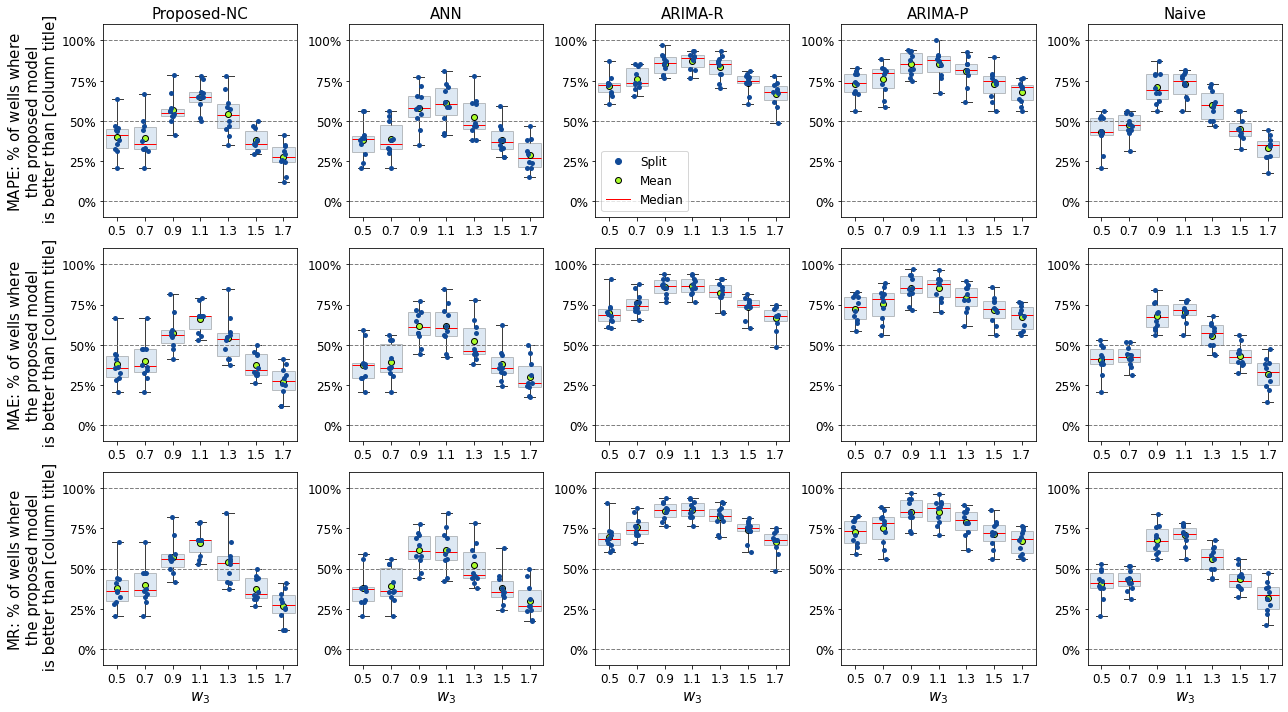

In [12]:
df1_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])
df2_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])
df3_total = pd.DataFrame(columns=['Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive'])

for this_w3 in all_w3s:

    path = current_dir+'/Analysis-SA/SA-w3/w3'+str(this_w3)+'/'
    proposed_mape_better_proposednc, proposed_mape_better_ann, proposed_mape_better_arimar, proposed_mape_better_arimap, proposed_mape_better_naive = [], [], [], [], []
    proposed_mae_better_proposednc, proposed_mae_better_ann, proposed_mae_better_arimar, proposed_mae_better_arimap, proposed_mae_better_naive = [], [], [], [], []
    proposed_mr_better_proposednc, proposed_mr_better_ann, proposed_mr_better_arimar, proposed_mr_better_arimap, proposed_mr_better_naive = [], [], [], [], []
    for rs in split_rs:
        df = pd.read_excel(path+'Metrics-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
        count_proposed_mape_better_proposednc, count_proposed_mape_better_ann, count_proposed_mape_better_arimar, count_proposed_mape_better_arimap, count_proposed_mape_better_naive = 0, 0, 0, 0, 0
        count_proposed_mae_better_proposednc, count_proposed_mae_better_ann, count_proposed_mae_better_arimar, count_proposed_mae_better_arimap, count_proposed_mae_better_naive = 0, 0, 0, 0, 0
        count_proposed_mr_better_proposednc, count_proposed_mr_better_ann, count_proposed_mr_better_arimar, count_proposed_mr_better_arimap, count_proposed_mr_better_naive = 0, 0, 0, 0, 0
        for j in range(len(df)):
            if df['Proposed_mape'][j] - df['ProposedNC_mape'][j] < 0:
                count_proposed_mape_better_proposednc += 1
            if df['Proposed_mape'][j] - df['ANN_mape'][j] < 0:
                count_proposed_mape_better_ann += 1
            if df['Proposed_mape'][j] - df['ARIMAR_mape'][j] < 0:
                count_proposed_mape_better_arimar += 1
            if df['Proposed_mape'][j] - df['ARIMAP_mape'][j] < 0:
                count_proposed_mape_better_arimap += 1
            if df['Proposed_mape'][j] - df['Naive_mape'][j] < 0:
                count_proposed_mape_better_naive += 1
            if df['Proposed_mae'][j] - df['ProposedNC_mae'][j] < 0:
                count_proposed_mae_better_proposednc += 1
            if df['Proposed_mae'][j] - df['ANN_mae'][j] < 0:
                count_proposed_mae_better_ann += 1
            if df['Proposed_mae'][j] - df['ARIMAR_mae'][j] < 0:
                count_proposed_mae_better_arimar += 1
            if df['Proposed_mae'][j] - df['ARIMAP_mae'][j] < 0:
                count_proposed_mae_better_arimap += 1
            if df['Proposed_mae'][j] - df['Naive_mae'][j] < 0:
                count_proposed_mae_better_naive += 1
            if df['Proposed_mr'][j] - df['ProposedNC_mr'][j] < 0:
                count_proposed_mr_better_proposednc += 1
            if df['Proposed_mr'][j] - df['ANN_mr'][j] < 0:
                count_proposed_mr_better_ann += 1
            if df['Proposed_mr'][j] - df['ARIMAR_mr'][j] < 0:
                count_proposed_mr_better_arimar += 1
            if df['Proposed_mr'][j] - df['ARIMAP_mr'][j] < 0:
                count_proposed_mr_better_arimap += 1
            if df['Proposed_mr'][j] - df['Naive_mr'][j] < 0:
                count_proposed_mr_better_naive += 1
        proposed_mape_better_proposednc.append(count_proposed_mape_better_proposednc/len(df))
        proposed_mape_better_ann.append(count_proposed_mape_better_ann/len(df))
        proposed_mape_better_arimar.append(count_proposed_mape_better_arimar/len(df))
        proposed_mape_better_arimap.append(count_proposed_mape_better_arimap/len(df))
        proposed_mape_better_naive.append(count_proposed_mape_better_naive/len(df))
        proposed_mae_better_proposednc.append(count_proposed_mae_better_proposednc/len(df))
        proposed_mae_better_ann.append(count_proposed_mae_better_ann/len(df))
        proposed_mae_better_arimar.append(count_proposed_mae_better_arimar/len(df))
        proposed_mae_better_arimap.append(count_proposed_mae_better_arimap/len(df))
        proposed_mae_better_naive.append(count_proposed_mae_better_naive/len(df))
        proposed_mr_better_proposednc.append(count_proposed_mr_better_proposednc/len(df))
        proposed_mr_better_ann.append(count_proposed_mr_better_ann/len(df))
        proposed_mr_better_arimar.append(count_proposed_mr_better_arimar/len(df))
        proposed_mr_better_arimap.append(count_proposed_mr_better_arimap/len(df))
        proposed_mr_better_naive.append(count_proposed_mr_better_naive/len(df))

    df1 = pd.DataFrame({'Proposed-NC': proposed_mape_better_proposednc,
                        'ANN': proposed_mape_better_ann,
                        'ARIMA-R': proposed_mape_better_arimar,
                        'ARIMA-P': proposed_mape_better_arimap,
                        'Naive': proposed_mape_better_naive})
    df2 = pd.DataFrame({'Proposed-NC': proposed_mae_better_proposednc,
                        'ANN': proposed_mae_better_ann,
                        'ARIMA-R': proposed_mae_better_arimar,
                        'ARIMA-P': proposed_mae_better_arimap,
                        'Naive': proposed_mae_better_naive})
    df3 = pd.DataFrame({'Proposed-NC': proposed_mr_better_proposednc,
                        'ANN': proposed_mr_better_ann,
                        'ARIMA-R': proposed_mr_better_arimar,
                        'ARIMA-P': proposed_mr_better_arimap,
                        'Naive': proposed_mr_better_naive})
    df1 = df1 * 100
    df2 = df2 * 100
    df3 = df3 * 100

    df1_total = pd.concat((df1_total, df1))
    df2_total = pd.concat((df2_total, df2))
    df3_total = pd.concat((df3_total, df3))

df1_total = df1_total.reset_index(drop=True)
df2_total = df2_total.reset_index(drop=True)
df3_total = df3_total.reset_index(drop=True)

f, axes = plt.subplots(3, 5, figsize=(18, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
ax11, ax12, ax13, ax14, ax15 = axes[2,0], axes[2,1], axes[2,2], axes[2,3], axes[2,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15]

for k in range(len(df1_total.columns)):
    df = pd.DataFrame(df1_total[df1_total.columns[k]])
    w3_values = []
    for i in range(len(all_w3s)):
        for j in range(1,11):
            w3_values.append(all_w3s[i])
    df['w3'] = w3_values

    df_reshaped = pd.DataFrame()
    for this_w3 in all_w3s:
        df_reshaped[str(this_w3)] = df[df['w3']==this_w3][df1_total.columns[k]].values

    axes_list[k] = sns.boxplot(data=df_reshaped, ax=axes_list[k], boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), 
                               showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
    sns.stripplot(data=df_reshaped, ax=axes_list[k], color='#114A97')

for k in range(len(df2_total.columns)):
    df = pd.DataFrame(df2_total[df2_total.columns[k]])
    w3_values = []
    for i in range(len(all_w3s)):
        for j in range(1,11):
            w3_values.append(all_w3s[i])
    df['w3'] = w3_values

    df_reshaped = pd.DataFrame()
    for this_w3 in all_w3s:
        df_reshaped[str(this_w3)] = df[df['w3']==this_w3][df2_total.columns[k]].values

    axes_list[k+5] = sns.boxplot(data=df_reshaped, ax=axes_list[k+5], boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), 
                               showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
    sns.stripplot(data=df_reshaped, ax=axes_list[k+5], color='#114A97')

for k in range(len(df2_total.columns)):
    df = pd.DataFrame(df2_total[df2_total.columns[k]])
    w3_values = []
    for i in range(len(all_w3s)):
        for j in range(1,11):
            w3_values.append(all_w3s[i])
    df['w3'] = w3_values

    df_reshaped = pd.DataFrame()
    for this_w3 in all_w3s:
        df_reshaped[str(this_w3)] = df[df['w3']==this_w3][df2_total.columns[k]].values

    axes_list[k+10] = sns.boxplot(data=df_reshaped, ax=axes_list[k+10], boxprops=dict(alpha=.3, facecolor='#8FB5DA'), whis=(0,100), medianprops=dict(color='red'), 
                               showmeans=True, meanprops=dict(marker='o', markerfacecolor='#A9FD2B', markeredgecolor='black'))
    sns.stripplot(data=df_reshaped, ax=axes_list[k+10], color='#114A97')

for ax in axes_list:
    ax.set_xlim(-0.5, 6.5)
    ax.hlines(0, -0.5, 6.5, color='grey', linewidth=1, linestyle='--')
    ax.hlines(50, -0.5, 6.5, color='grey', linewidth=1, linestyle='--')
    ax.hlines(100, -0.5, 6.5, color='grey', linewidth=1, linestyle='--')
    ax.set_ylim(-10, 110)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
ax1.set_ylabel('MAPE: $\%$ of wells where \n the proposed model \n is better than [column title]', size=15)
ax6.set_ylabel('MAE: $\%$ of wells where \n the proposed model \n is better than [column title]', size=15)
ax11.set_ylabel('MR: $\%$ of wells where \n the proposed model \n is better than [column title]', size=15)
ax11.set_xlabel('$w_3$', size=15)
ax12.set_xlabel('$w_3$', size=15)
ax13.set_xlabel('$w_3$', size=15)
ax14.set_xlabel('$w_3$', size=15)
ax15.set_xlabel('$w_3$', size=15)
ax1.set_title('Proposed-NC', size=15)
ax2.set_title('ANN', size=15)
ax3.set_title('ARIMA-R', size=15)
ax4.set_title('ARIMA-P', size=15)
ax5.set_title('Naive', size=15)

legend_elements = [Line2D([], [], color='#114A97', marker='o', linestyle='', label='Split'),
                   Line2D([], [], color='#A9FD2B', marker='o', markeredgecolor='black', linestyle='', label='Mean'),
                   Line2D([0], [0], color='red', lw=1, label='Median')]
ax3.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_4.png')